## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [1]:
#!pip install -r requirements.txt

In [2]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow import random 
from tensorflow.keras import callbacks

sns.set()

---

## Cargar y preparar los datos.

In [3]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol_ve_ic.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Futuros': 'Vol. Futuros'})
df

Fecha  Vol. Futuros      TRM  Precio Interno    PI    MHI   FNI    SI
0   2020-01-01      1.289946  3277.14        975000.0  0.00   0.00  0.00  0.00
1   2020-01-02      0.735046  3277.14        945000.0  0.00   0.00  0.00  0.00
2   2020-01-03      0.591834  3258.84        940000.0  0.00   0.00  0.00  0.00
3   2020-01-04      1.367154  3262.05        930000.0  0.00   0.00  0.00  0.00
4   2020-01-05      1.505321  3262.05        920000.0  0.00   0.00  0.00  0.00
..         ...           ...      ...             ...   ...    ...   ...   ...
913 2022-07-02      0.778572  4198.77       2270000.0  4.66  25.71  0.19 -3.56
914 2022-07-03      0.819483  4198.77       2270000.0  0.42   7.76  0.00 -3.67
915 2022-07-04      0.843804  4198.77       2270000.0  0.54  31.37  0.27 -5.85
916 2022-07-05      0.850985  4198.77       2280000.0  0.48  38.21  0.12 -4.97
917 2022-07-06      0.840437  4259.86       2302000.0  0.52  27.93  0.00 -7.87

[918 rows x 8 columns]

---

## Desarrollo del modelo

In [4]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [5]:
df_stats=df

In [6]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["Vol. Futuros"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
df_label_normalize=sc.fit_transform(df_label)
df_data_normalize=sc2.fit_transform(df_data)


In [7]:
#last index of the train data
eight_percent=int(len_data*0.7)

#split the data normalize
df_train=df_data_normalize[:eight_percent]
df_test=df_data_normalize[eight_percent:]

#split labels normalize
df_train_y_normalize=df_label_normalize[:eight_percent]
df_test_y_normalize=df_label_normalize[eight_percent:]

#split the original labels
df_train_y=df_label[:eight_percent]
df_test_y=df_label[eight_percent:]

In [8]:
def plot_metrics(history):
        # plot MAE and loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['loss'], label='loss')
    plt.ylabel("value")
    plt.xlabel("epoch")
    plt.title("error a través de los epochs")
    plt.legend()
    plt.show()

In [9]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [10]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [11]:
def Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons,attributes,epochss,batch_sizze,lag):
    #reshape train data
    lag=lag
    len_df_train=df_train.shape[0]
    X_train=[]
    Y_train=[]
    for i in range(lag,len_df_train):
        X_train.append(df_train[i-lag:i])
        Y_train.append(df_train_y_normalize[i])

    X_train,Y_train=np.array(X_train),np.array(Y_train)
    print(X_train.shape,Y_train.shape)
    
    #reshape test data
    len_df_test=df_test.shape[0]
    X_test=[]
    Y_test=[]
    for i in range(lag,len_df_test):
        X_test.append(df_test[i-lag:i])
        Y_test.append(df_test_y_normalize[i])

    X_test,Y_test=np.array(X_test),np.array(Y_test)
    print(X_test.shape,Y_test.shape)
    
    
    #set the seed
    random.set_seed(7)

    #optional----
    #callback to early stopping and prevent overfitting
    #callback =callbacks.EarlyStopping(monitor='mae', patience=3)

    #make the model
    model=Sequential()
    model.add(LSTM(units=neurons,return_sequences=False,input_shape=(lag,attributes)))
    model.add(Dense(1))
    model.compile(optimizer='adamax',loss='mean_squared_error',metrics=['mae'])
    
    #fit the model with the train data
    history=model.fit(X_train,Y_train,validation_split=0.2,epochs=epochss,batch_size=batch_sizze)
    
    #plot metrics
    plot_metrics(history)
    
    # make predictions
    trainPredict = model.predict(X_train)

    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    model.reset_states()
    testPredict = model.predict(X_test)


    # invert transformation
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:eight_percent],"typeLSTM":["train"]*len(trainPredict.flatten()),"LSTM" :trainPredict.flatten()}
        ,{"Fecha":df_stats.Fecha[eight_percent+lag:],"typeLSTM":["test"]*len(testPredict.flatten()),"LSTM":testPredict.flatten()}]
    
    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()[lag:]+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()[lag:]+1, testPredict.flatten()+1,False)}

## Resultados

(637, 5, 7) (637, 1)
(271, 5, 7) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 35ms/step - loss: 0.9992 - mae: 0.7727 - val_loss: 1.6891 - val_mae: 0.8096
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9654 - mae: 0.7454 - val_loss: 1.6706 - val_mae: 0.8058
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9481 - mae: 0.7348 - val_loss: 1.6457 - val_mae: 0.8025
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9366 - mae: 0.7252 - val_loss: 1.6262 - val_mae: 0.7993
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9272 - mae: 0.7206 - val_loss: 1.6121 - val_mae: 0.7980
Epoch 6/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9207 - mae: 0.7169 - val_loss: 1.5935 - val_mae: 0.7954
Epoch 7/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9152 - mae: 0.7133 - val_loss: 1.5842 - val_mae: 0.7936
Epoch 8/100
32/32 [=====================

Epoch 63/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7919 - mae: 0.6673 - val_loss: 1.4335 - val_mae: 0.8017
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7903 - mae: 0.6664 - val_loss: 1.4342 - val_mae: 0.8024
Epoch 65/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7891 - mae: 0.6653 - val_loss: 1.4334 - val_mae: 0.8027
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7864 - mae: 0.6646 - val_loss: 1.4322 - val_mae: 0.8027
Epoch 67/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7857 - mae: 0.6657 - val_loss: 1.4386 - val_mae: 0.8054
Epoch 68/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7838 - mae: 0.6641 - val_loss: 1.4366 - val_mae: 0.8061
Epoch 69/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7818 - mae: 0.6636 - val_loss: 1.4392 - val_mae: 0.8075
Epoch 70/100
32/32 [==============================] - 0s 8ms/step - loss: 0.

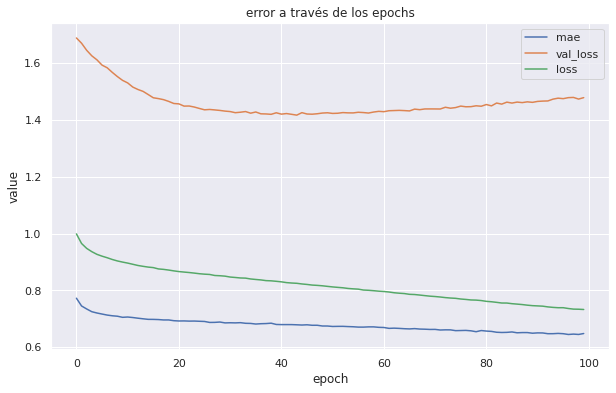

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.3695096376827292
MAE is : 0.8537801841216726
RMSE is : 1.1702604999241533
MAPE is : 41.71660741247725
Evaluation metric results:
MSE is : 1.2903495988254121
MAE is : 0.8992867717026818
RMSE is : 1.1359355610356654
MAPE is : 46.08949508602961
(637, 5, 7) (637, 1)
(271, 5, 7) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 33ms/step - loss: 0.9262 - mae: 0.7051 - val_loss: 1.4838 - val_mae: 0.8046
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9123 - mae: 0.7038 - val_loss: 1.4761 - val_mae: 0.8048
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9055 - mae: 0.7046 - val_loss: 1.4673 - val_mae: 0.8054
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8999 - mae: 0.7008 - val_loss: 1.4607 - val_mae: 0.8053
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8951 - mae: 0.7003 - val_lo

Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7590 - mae: 0.6583 - val_loss: 1.5146 - val_mae: 0.8757
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7571 - mae: 0.6592 - val_loss: 1.5119 - val_mae: 0.8764
Epoch 62/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7561 - mae: 0.6554 - val_loss: 1.5161 - val_mae: 0.8771
Epoch 63/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7530 - mae: 0.6583 - val_loss: 1.5203 - val_mae: 0.8807
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7527 - mae: 0.6555 - val_loss: 1.5228 - val_mae: 0.8820
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7507 - mae: 0.6553 - val_loss: 1.5236 - val_mae: 0.8836
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7473 - mae: 0.6549 - val_loss: 1.5209 - val_mae: 0.8830
Epoch 67/100
32/32 [==============================] - 0s 8ms/step - loss: 0.

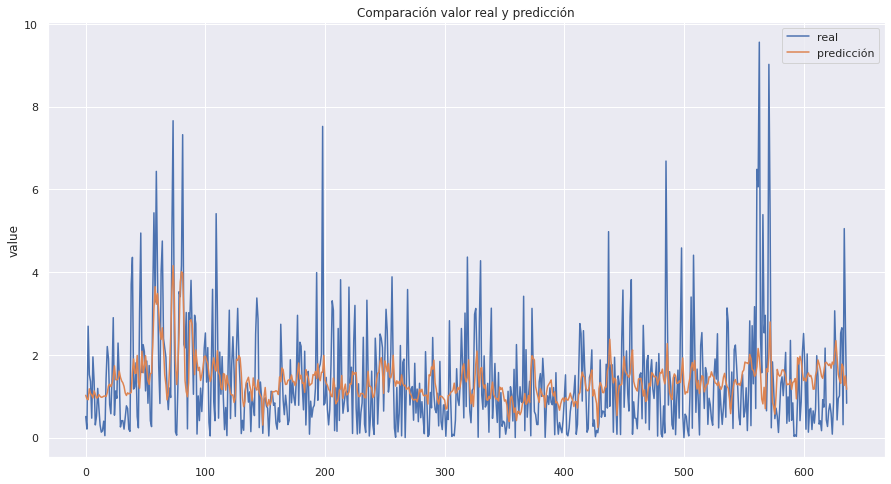

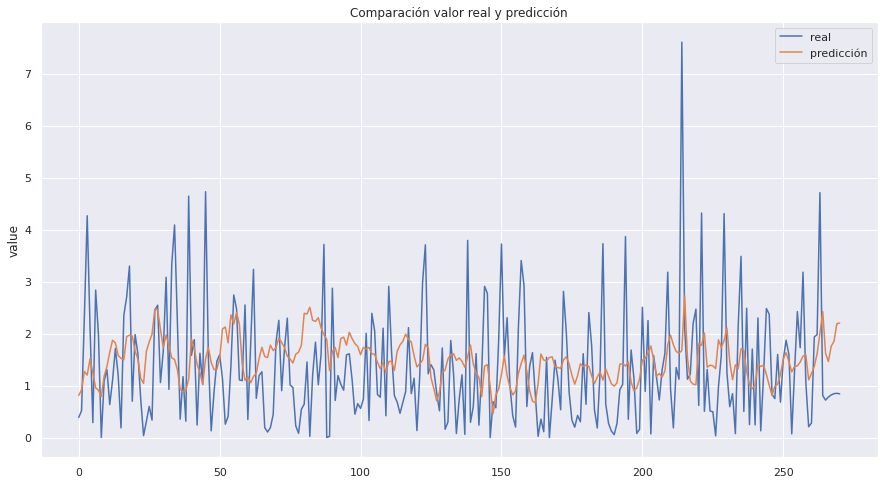

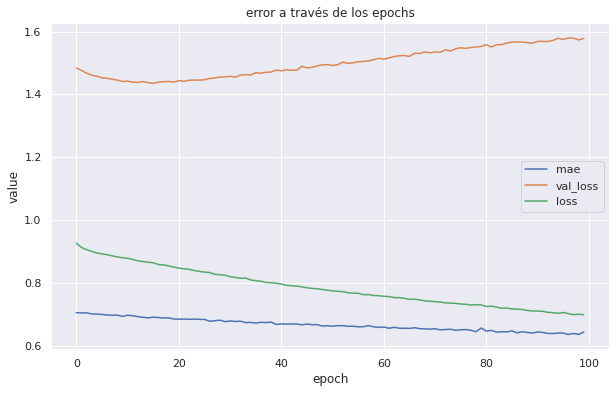

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.3536233557786894
MAE is : 0.8653860519721782
RMSE is : 1.163453203089273
MAPE is : 43.18598475974833
Evaluation metric results:
MSE is : 1.486207172539206
MAE is : 0.9878082498457692
RMSE is : 1.2191009689682009
MAPE is : 54.92709477398421
(637, 5, 7) (637, 1)
(271, 5, 7) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 31ms/step - loss: 0.9696 - mae: 0.7223 - val_loss: 1.5547 - val_mae: 0.8207
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9314 - mae: 0.7099 - val_loss: 1.5228 - val_mae: 0.8199
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9153 - mae: 0.7117 - val_loss: 1.5012 - val_mae: 0.8225
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9036 - mae: 0.7020 - val_loss: 1.4886 - val_mae: 0.8237
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8953 - mae: 0.7034 - val_loss

Epoch 60/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7386 - mae: 0.6556 - val_loss: 1.7162 - val_mae: 0.9781
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7363 - mae: 0.6567 - val_loss: 1.7139 - val_mae: 0.9800
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7356 - mae: 0.6508 - val_loss: 1.7107 - val_mae: 0.9777
Epoch 63/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7300 - mae: 0.6567 - val_loss: 1.7344 - val_mae: 0.9859
Epoch 64/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7302 - mae: 0.6516 - val_loss: 1.7318 - val_mae: 0.9869
Epoch 65/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7277 - mae: 0.6505 - val_loss: 1.7365 - val_mae: 0.9899
Epoch 66/100
32/32 [==============================] - 0s 10ms/step - loss: 0.7224 - mae: 0.6504 - val_loss: 1.7179 - val_mae: 0.9857
Epoch 67/100
32/32 [==============================] - 0s 9ms/step - loss: 0

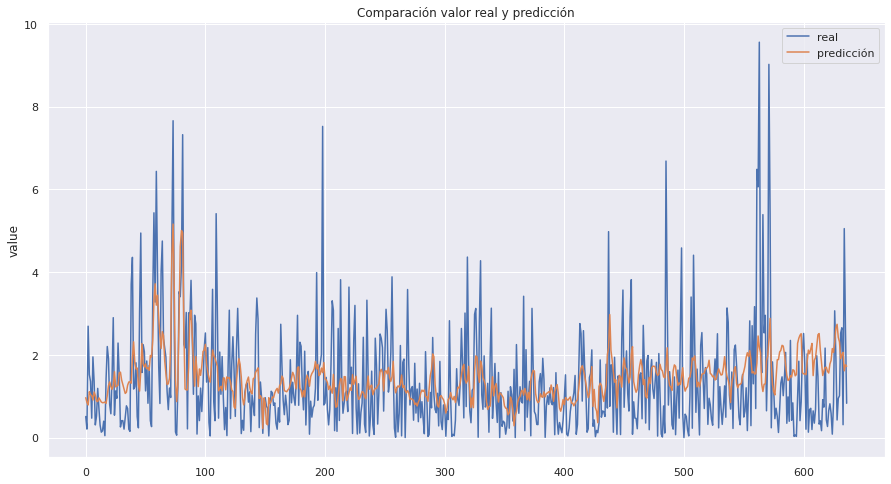

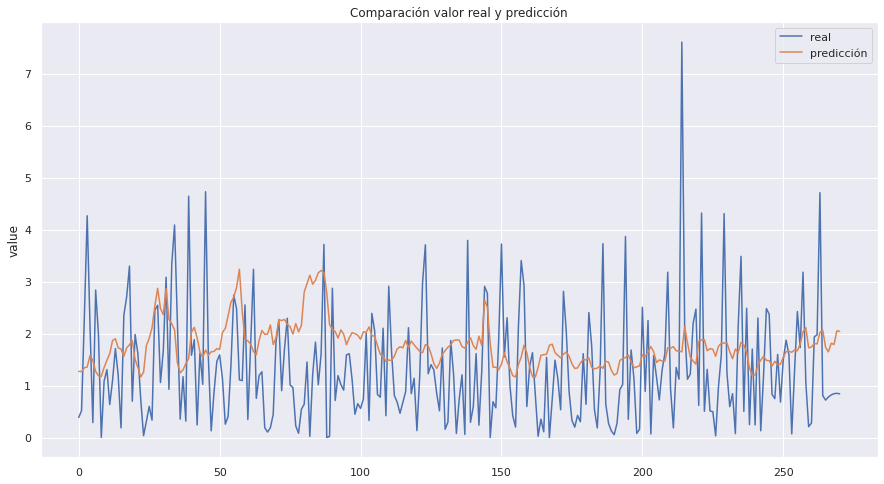

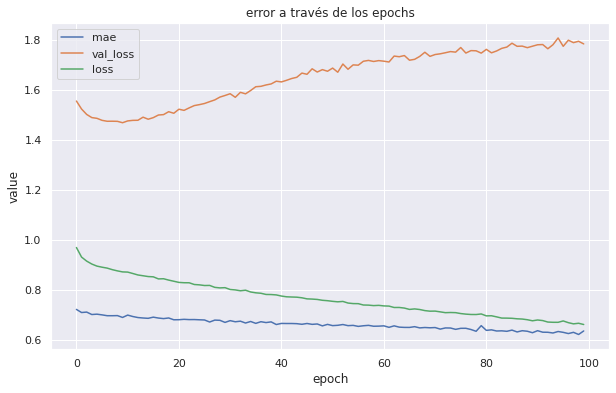

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.3706414141262426
MAE is : 0.8697789427294631
RMSE is : 1.1707439575441945
MAPE is : 43.56951166493133
Evaluation metric results:
MSE is : 2.302660910376812
MAE is : 1.2612262497153282
RMSE is : 1.517452111394891
MAPE is : 71.08235915236091
(637, 5, 7) (637, 1)
(271, 5, 7) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 0.9446 - mae: 0.7169 - val_loss: 1.4445 - val_mae: 0.8040
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9170 - mae: 0.7072 - val_loss: 1.4205 - val_mae: 0.8049
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9047 - mae: 0.7115 - val_loss: 1.4136 - val_mae: 0.8095
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.8954 - mae: 0.6984 - val_loss: 1.4053 - val_mae: 0.8111
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.8875 - mae: 0.7039 - val_

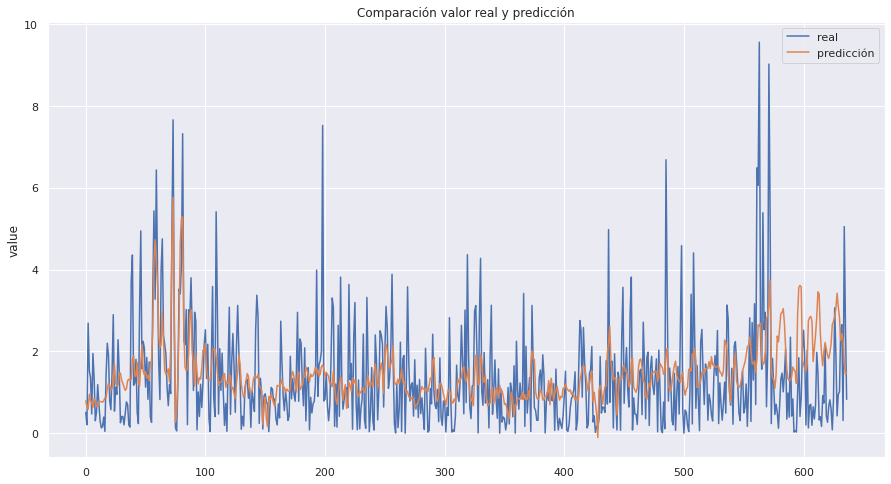

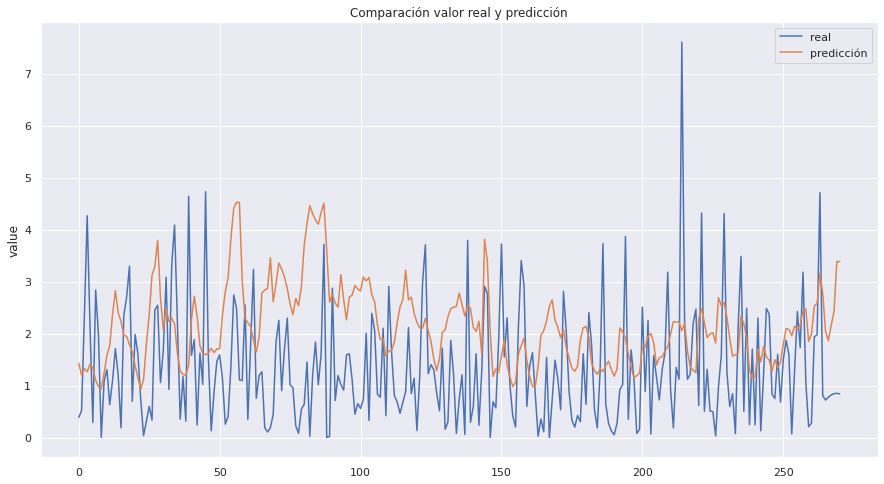

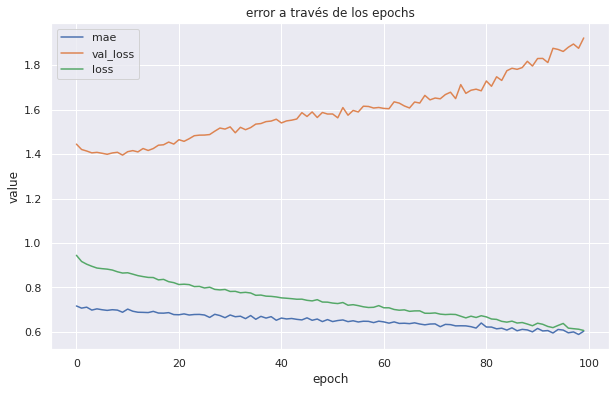

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.3490765989221234
MAE is : 0.8435339680234957
RMSE is : 1.161497567333709
MAPE is : 41.66693666566365
Evaluation metric results:
MSE is : 2.7576730956443516
MAE is : 1.3821626636975344
RMSE is : 1.6606243090007902
MAPE is : 78.821448619609
(637, 5, 7) (637, 1)
(271, 5, 7) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 40ms/step - loss: 0.9448 - mae: 0.7171 - val_loss: 1.4132 - val_mae: 0.7954
Epoch 2/100
32/32 [==============================] - 1s 17ms/step - loss: 0.9130 - mae: 0.7081 - val_loss: 1.3950 - val_mae: 0.7974
Epoch 3/100
32/32 [==============================] - 1s 16ms/step - loss: 0.8996 - mae: 0.7110 - val_loss: 1.4045 - val_mae: 0.8068
Epoch 4/100
32/32 [==============================] - 1s 17ms/step - loss: 0.8892 - mae: 0.6973 - val_loss: 1.3950 - val_mae: 0.8082
Epoch 5/100
32/32 [==============================] - 1s 16ms/step - loss: 0.8791 - mae: 0.7033 - val_l

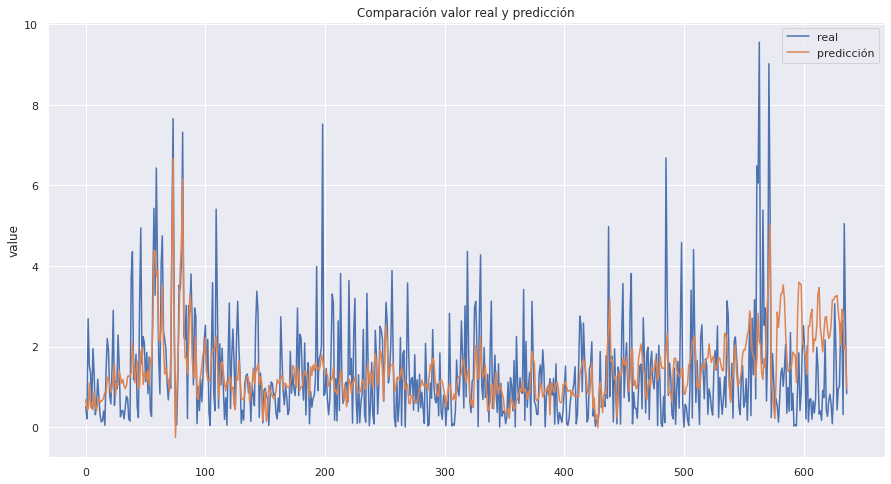

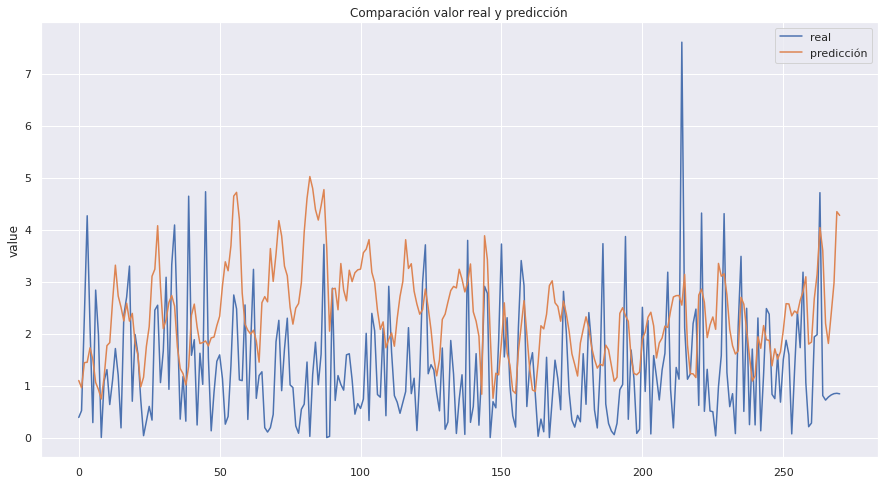

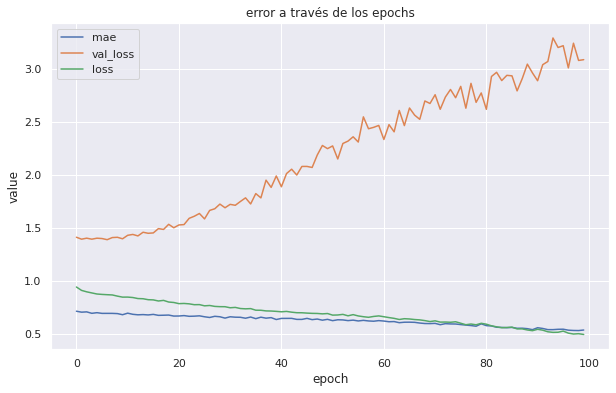

9/9 [==============================] - 0s 7ms/step
Evaluation metric results:
MSE is : 1.5666996290885682
MAE is : 0.8355015540282205
RMSE is : 1.2516787243891974
MAPE is : 42.180224527345636
Evaluation metric results:
MSE is : 3.974016016021916
MAE is : 1.594881074369749
RMSE is : 1.9934934201100127
MAPE is : 88.53416324200539
(637, 5, 7) (637, 1)
(271, 5, 7) (271, 1)
Epoch 1/100
32/32 [==============================] - 5s 57ms/step - loss: 0.9540 - mae: 0.7239 - val_loss: 1.4202 - val_mae: 0.8014
Epoch 2/100
32/32 [==============================] - 1s 32ms/step - loss: 0.9090 - mae: 0.7087 - val_loss: 1.3881 - val_mae: 0.8009
Epoch 3/100
32/32 [==============================] - 1s 35ms/step - loss: 0.8955 - mae: 0.7127 - val_loss: 1.4143 - val_mae: 0.8129
Epoch 4/100
32/32 [==============================] - 1s 35ms/step - loss: 0.8841 - mae: 0.6957 - val_loss: 1.3990 - val_mae: 0.8115
Epoch 5/100
32/32 [==============================] - 1s 35ms/step - loss: 0.8727 - mae: 0.7047 - val

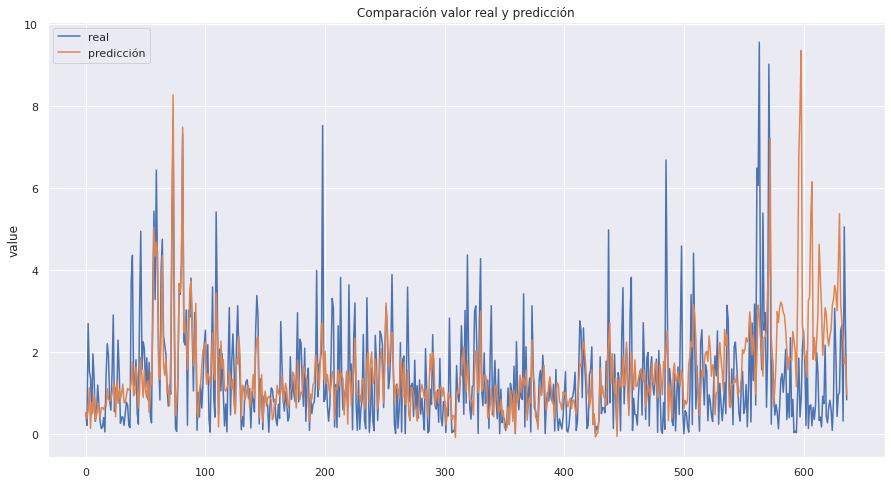

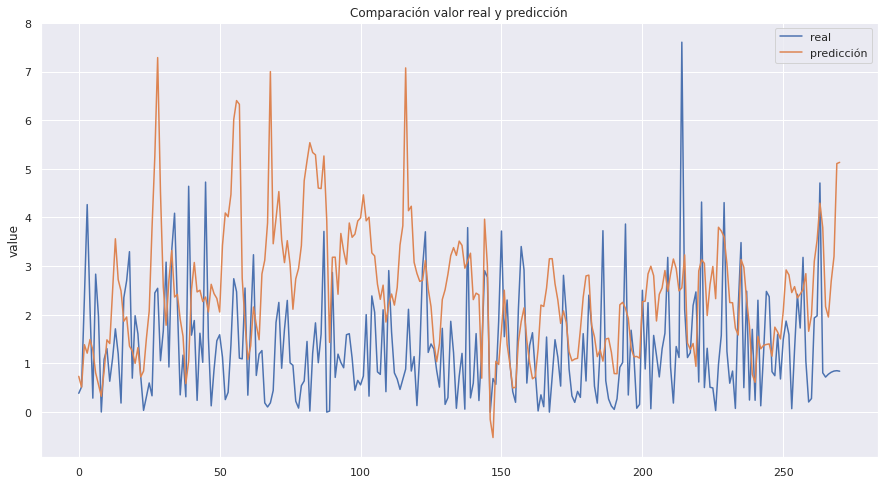

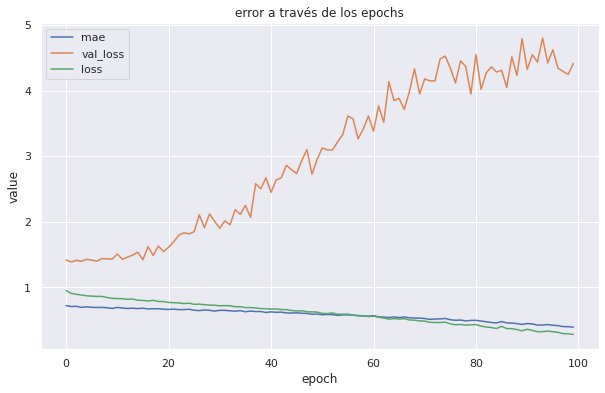

9/9 [==============================] - 0s 12ms/step
Evaluation metric results:
MSE is : 1.717958260689856
MAE is : 0.7760954110221705
RMSE is : 1.3107090679055577
MAPE is : 39.91749647740747
Evaluation metric results:
MSE is : 10.645502725722412
MAE is : 2.743481125557636
RMSE is : 3.262744661434972
MAPE is : 150.81547863335797
(634, 8, 7) (634, 1)
(268, 8, 7) (268, 1)
Epoch 1/100
32/32 [==============================] - 3s 27ms/step - loss: 0.9576 - mae: 0.7127 - val_loss: 1.5438 - val_mae: 0.8522
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9412 - mae: 0.7123 - val_loss: 1.5343 - val_mae: 0.8513
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9342 - mae: 0.7127 - val_loss: 1.5274 - val_mae: 0.8515
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9278 - mae: 0.7112 - val_loss: 1.5192 - val_mae: 0.8506
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9223 - mae: 0.7101 - val_los

Epoch 60/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8141 - mae: 0.6747 - val_loss: 1.5221 - val_mae: 0.8905
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8137 - mae: 0.6733 - val_loss: 1.5241 - val_mae: 0.8912
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8114 - mae: 0.6733 - val_loss: 1.5291 - val_mae: 0.8933
Epoch 63/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8101 - mae: 0.6738 - val_loss: 1.5302 - val_mae: 0.8945
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8088 - mae: 0.6732 - val_loss: 1.5347 - val_mae: 0.8958
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8067 - mae: 0.6726 - val_loss: 1.5367 - val_mae: 0.8967
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8059 - mae: 0.6718 - val_loss: 1.5383 - val_mae: 0.8973
Epoch 67/100
32/32 [==============================] - 0s 7ms/step - loss: 0.

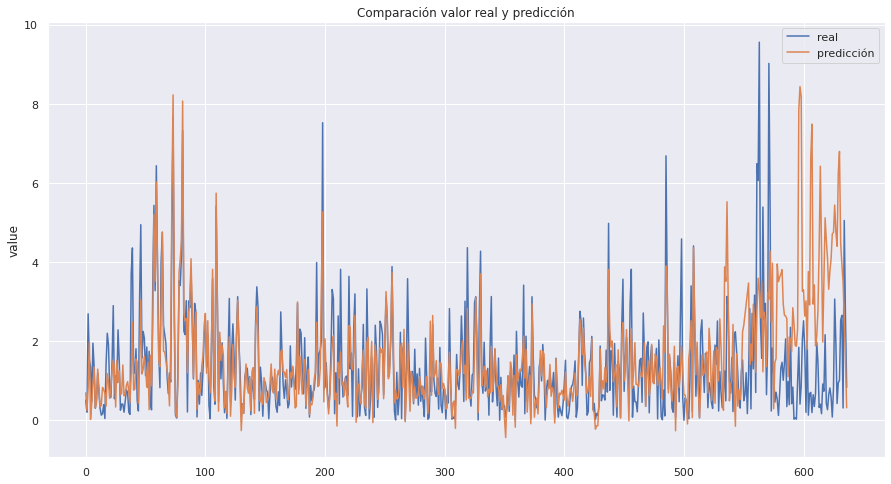

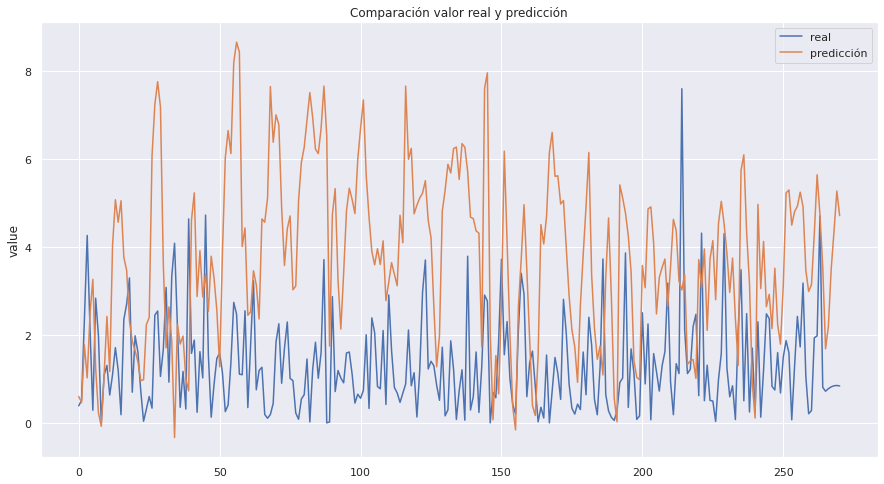

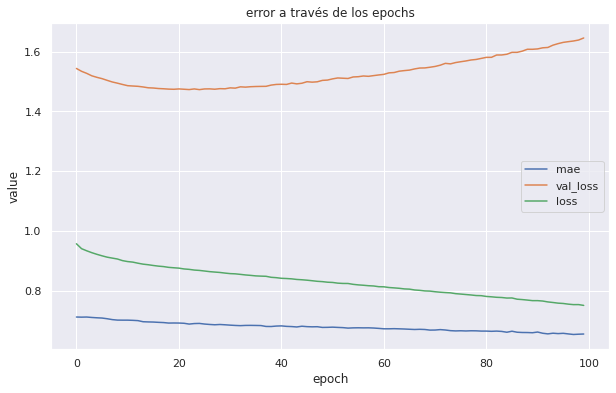

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.445677378451013
MAE is : 0.8890558481393672
RMSE is : 1.2023632472971773
MAPE is : 44.67790833068004
Evaluation metric results:
MSE is : 1.9064463696580758
MAE is : 1.1788611515480194
RMSE is : 1.3807412392110536
MAPE is : 68.4617732286682
(634, 8, 7) (634, 1)
(268, 8, 7) (268, 1)
Epoch 1/100
32/32 [==============================] - 3s 26ms/step - loss: 1.0391 - mae: 0.7880 - val_loss: 1.6828 - val_mae: 0.8141
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9694 - mae: 0.7295 - val_loss: 1.6387 - val_mae: 0.8044
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9490 - mae: 0.7171 - val_loss: 1.6060 - val_mae: 0.8005
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9333 - mae: 0.7109 - val_loss: 1.5787 - val_mae: 0.7967
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9225 - mae: 0.7087 - val_loss

Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7544 - mae: 0.6519 - val_loss: 1.4785 - val_mae: 0.8321
Epoch 61/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7532 - mae: 0.6480 - val_loss: 1.4862 - val_mae: 0.8354
Epoch 62/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7493 - mae: 0.6506 - val_loss: 1.4886 - val_mae: 0.8368
Epoch 63/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7472 - mae: 0.6504 - val_loss: 1.4905 - val_mae: 0.8401
Epoch 64/100
32/32 [==============================] - 0s 10ms/step - loss: 0.7424 - mae: 0.6477 - val_loss: 1.4977 - val_mae: 0.8420
Epoch 65/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7393 - mae: 0.6460 - val_loss: 1.4989 - val_mae: 0.8433
Epoch 66/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7370 - mae: 0.6434 - val_loss: 1.5004 - val_mae: 0.8448
Epoch 67/100
32/32 [==============================] - 0s 9ms/step - loss: 0

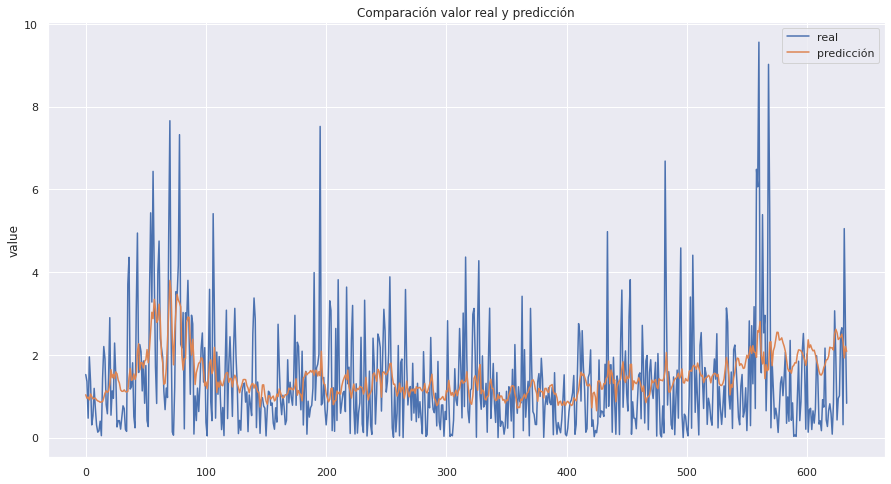

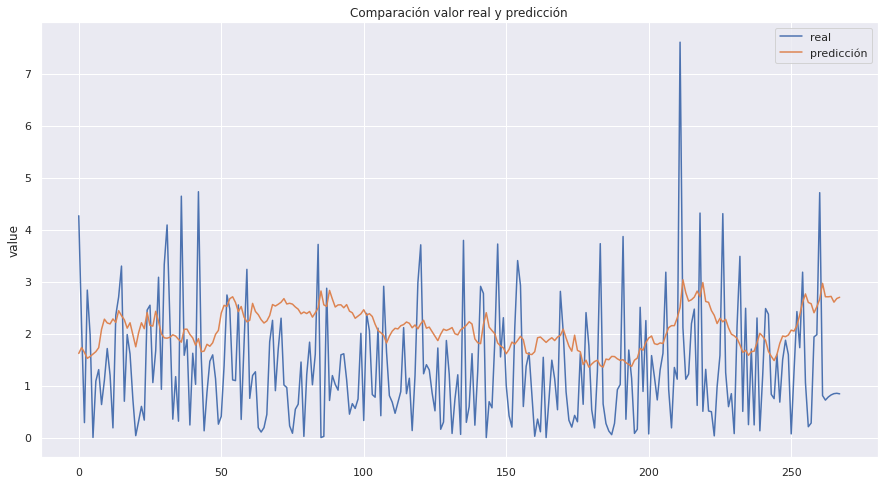

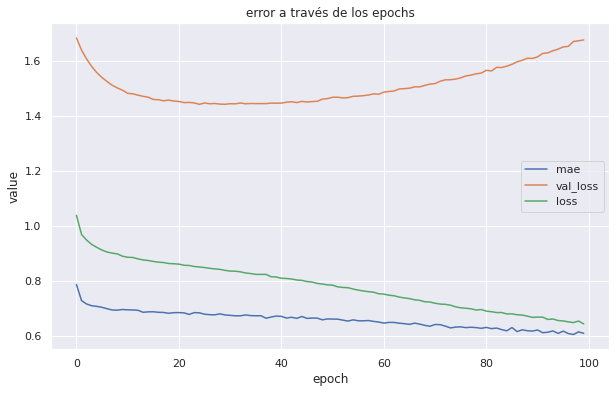

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.3168158485561685
MAE is : 0.8404168818152468
RMSE is : 1.1475259685759485
MAPE is : 41.574954679109744
Evaluation metric results:
MSE is : 1.2965701765867859
MAE is : 0.8709522935899789
RMSE is : 1.1386703546623078
MAPE is : 41.72606720387597
(634, 8, 7) (634, 1)
(268, 8, 7) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 0.9841 - mae: 0.7297 - val_loss: 1.5652 - val_mae: 0.8400
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9260 - mae: 0.7057 - val_loss: 1.5212 - val_mae: 0.8343
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9105 - mae: 0.7076 - val_loss: 1.5020 - val_mae: 0.8320
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9003 - mae: 0.7010 - val_loss: 1.4774 - val_mae: 0.8290
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.8938 - mae: 0.7016 - v

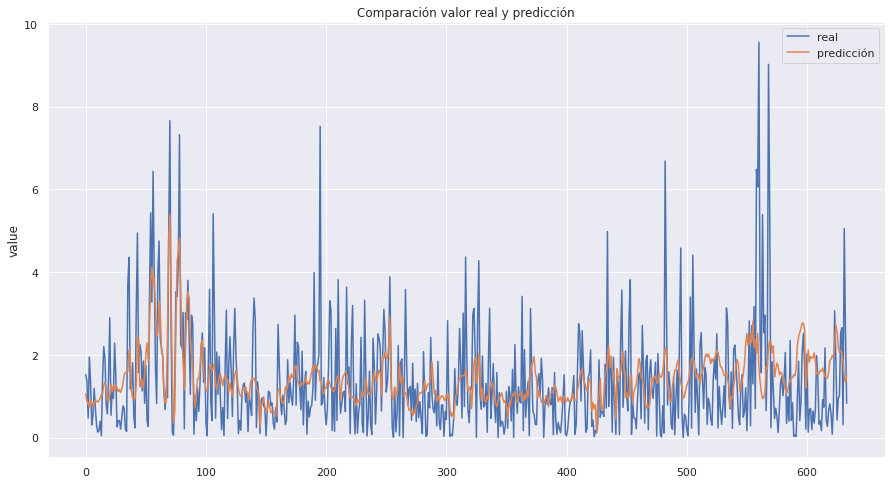

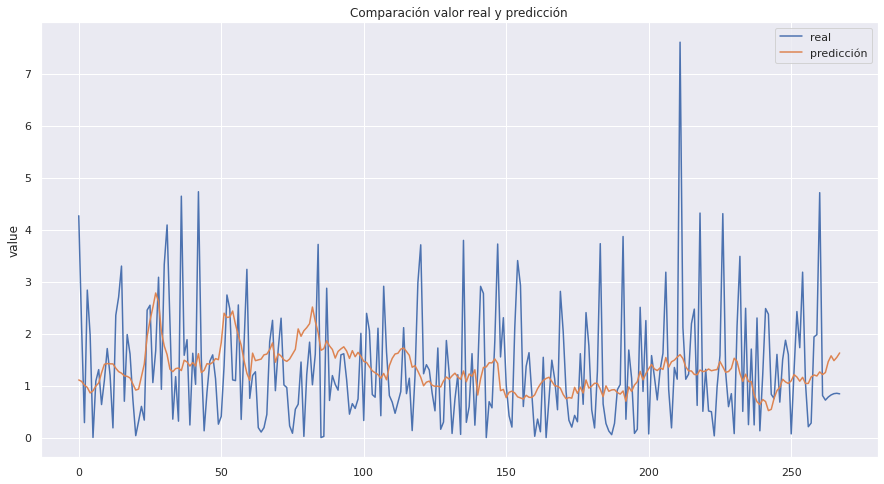

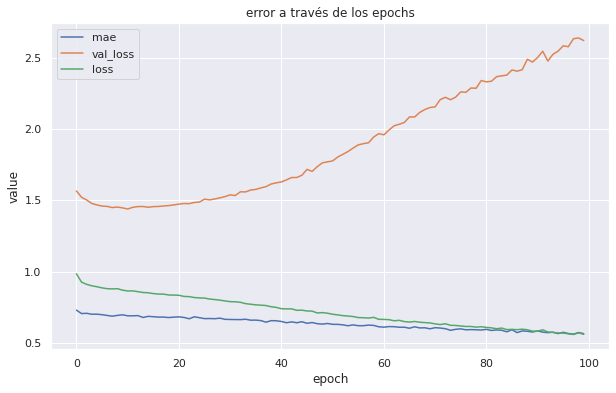

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.4935614456546396
MAE is : 0.8806583151016838
RMSE is : 1.2221135158628431
MAPE is : 45.02410453461616
Evaluation metric results:
MSE is : 1.6786257385919063
MAE is : 1.0387442374011309
RMSE is : 1.2956178983758702
MAPE is : 54.27379214294572
(634, 8, 7) (634, 1)
(268, 8, 7) (268, 1)
Epoch 1/100
32/32 [==============================] - 5s 36ms/step - loss: 0.9368 - mae: 0.7114 - val_loss: 1.4094 - val_mae: 0.8007
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9040 - mae: 0.6951 - val_loss: 1.3923 - val_mae: 0.8001
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.8966 - mae: 0.7005 - val_loss: 1.3967 - val_mae: 0.8033
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.8899 - mae: 0.6935 - val_loss: 1.3852 - val_mae: 0.8054
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.8860 - mae: 0.6987 - va

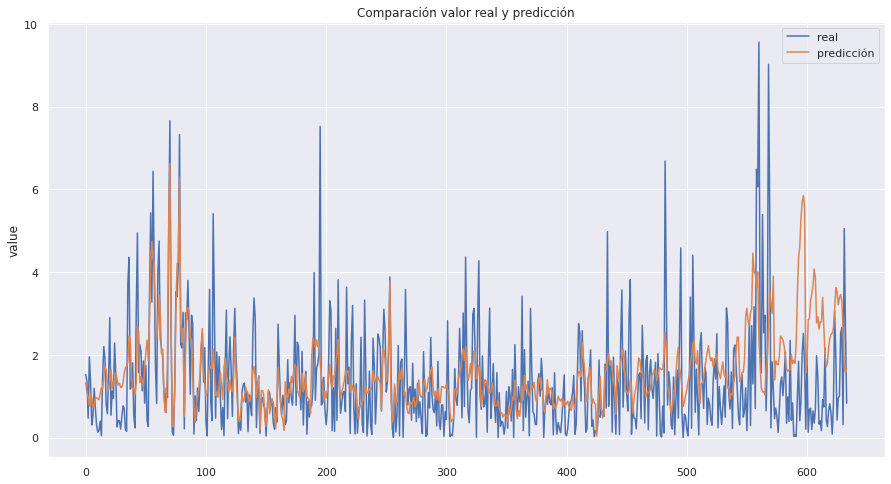

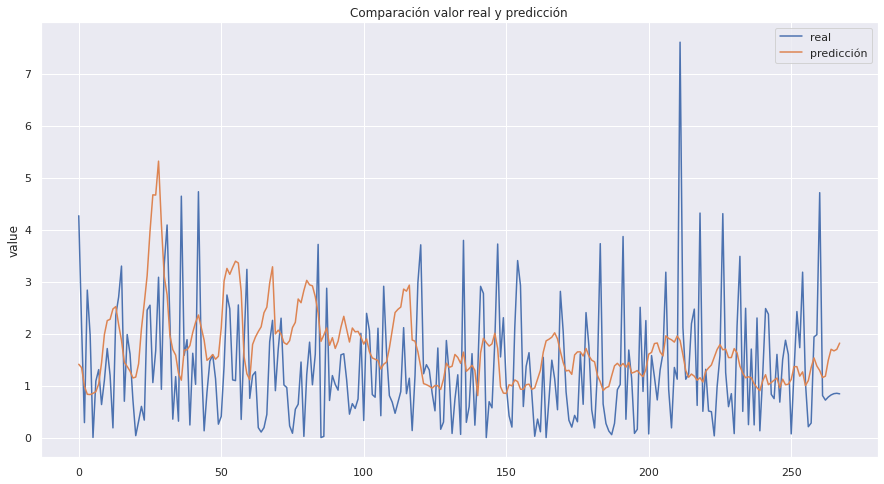

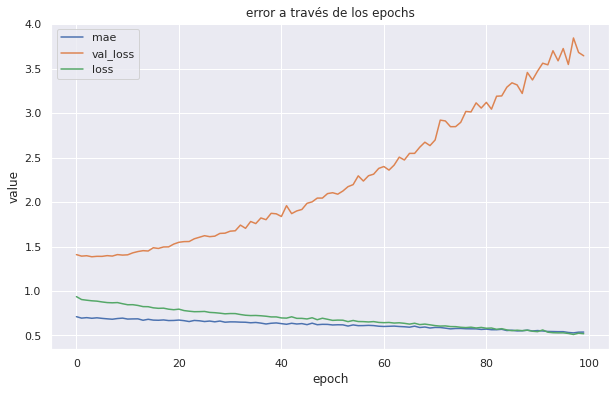

9/9 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 1.7440144278704757
MAE is : 0.8882721183294953
RMSE is : 1.3206113841211864
MAPE is : 45.45669782974585
Evaluation metric results:
MSE is : 2.729234378339554
MAE is : 1.2872391938555263
RMSE is : 1.652039460285242
MAPE is : 66.55093765472108
(634, 8, 7) (634, 1)
(268, 8, 7) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 42ms/step - loss: 0.9648 - mae: 0.7239 - val_loss: 1.4350 - val_mae: 0.8112
Epoch 2/100
32/32 [==============================] - 1s 20ms/step - loss: 0.9076 - mae: 0.6992 - val_loss: 1.4008 - val_mae: 0.8039
Epoch 3/100
32/32 [==============================] - 1s 21ms/step - loss: 0.8990 - mae: 0.7032 - val_loss: 1.4080 - val_mae: 0.8058
Epoch 4/100
32/32 [==============================] - 1s 19ms/step - loss: 0.8896 - mae: 0.6962 - val_loss: 1.3804 - val_mae: 0.8066
Epoch 5/100
32/32 [==============================] - 1s 21ms/step - loss: 0.8855 - mae: 0.7009 - val_

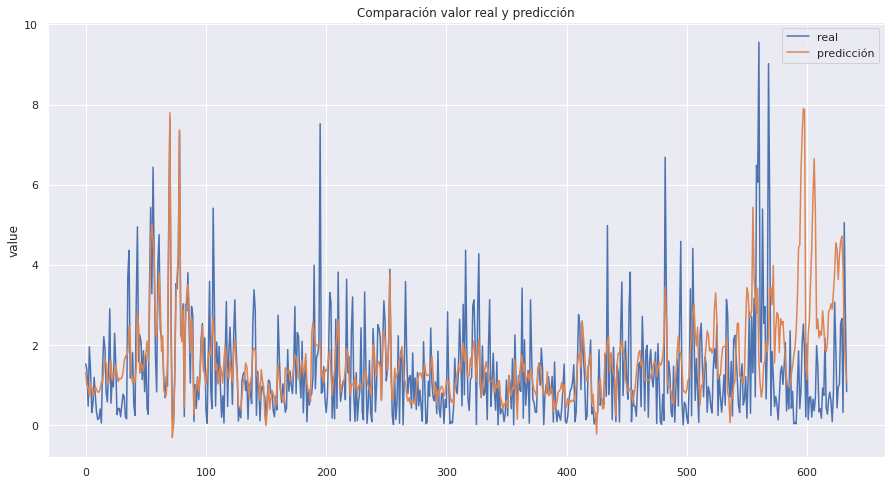

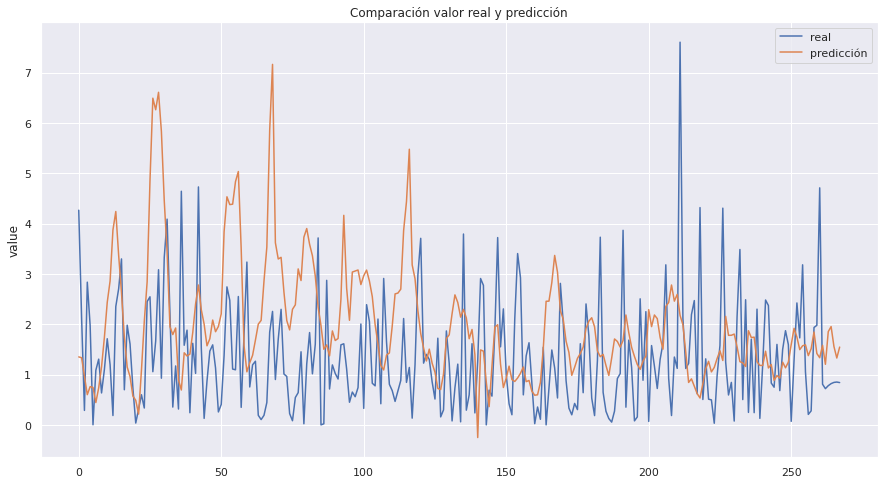

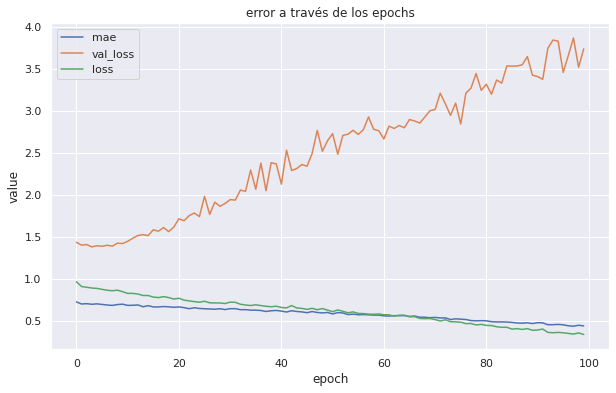

9/9 [==============================] - 0s 7ms/step
Evaluation metric results:
MSE is : 1.5376712370685695
MAE is : 0.7976359221531549
RMSE is : 1.2400287242917276
MAPE is : 40.86147024242073
Evaluation metric results:
MSE is : 3.2318937584402834
MAE is : 1.3251308431449704
RMSE is : 1.7977468560507297
MAPE is : 65.3569518505121
(634, 8, 7) (634, 1)
(268, 8, 7) (268, 1)
Epoch 1/100
32/32 [==============================] - 5s 68ms/step - loss: 0.9850 - mae: 0.7338 - val_loss: 1.4021 - val_mae: 0.8011
Epoch 2/100
32/32 [==============================] - 1s 44ms/step - loss: 0.9048 - mae: 0.6958 - val_loss: 1.3748 - val_mae: 0.7939
Epoch 3/100
32/32 [==============================] - 1s 45ms/step - loss: 0.8919 - mae: 0.7017 - val_loss: 1.3820 - val_mae: 0.7939
Epoch 4/100
32/32 [==============================] - 1s 47ms/step - loss: 0.8770 - mae: 0.6930 - val_loss: 1.3500 - val_mae: 0.8010
Epoch 5/100
32/32 [==============================] - 1s 47ms/step - loss: 0.8678 - mae: 0.6972 - val

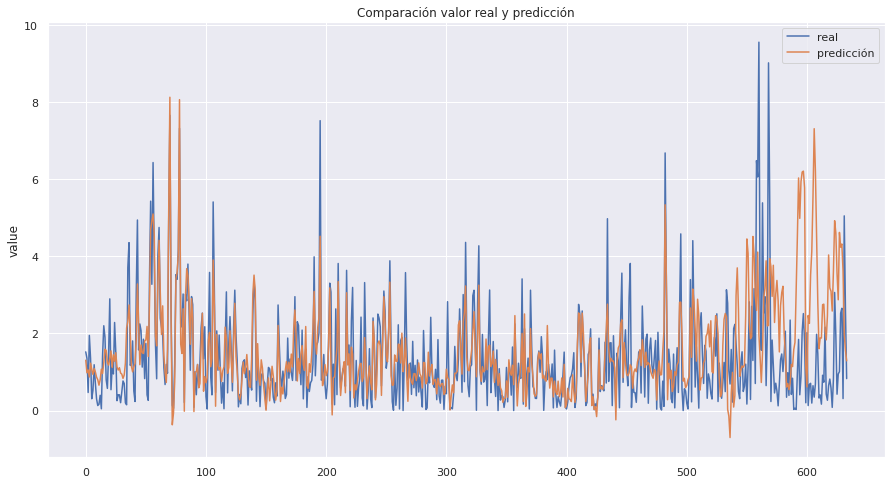

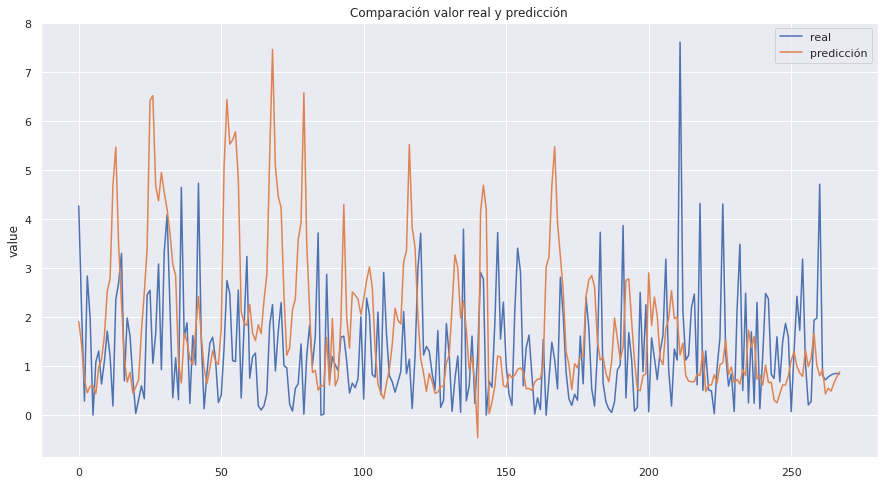

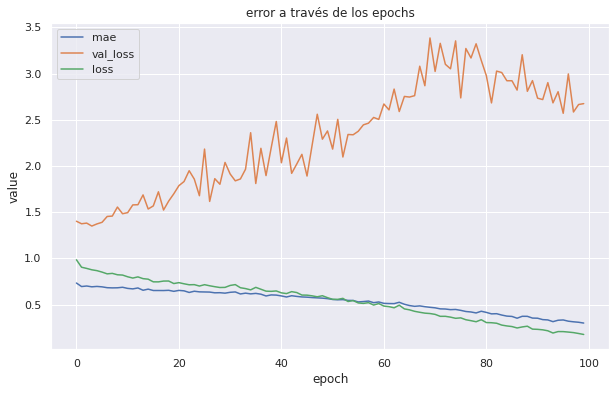

9/9 [==============================] - 0s 20ms/step
Evaluation metric results:
MSE is : 1.0228490638883614
MAE is : 0.5759558345199101
RMSE is : 1.0113600070639344
MAPE is : 29.546486243233645
Evaluation metric results:
MSE is : 3.7479848736490404
MAE is : 1.4532046503330602
RMSE is : 1.9359712997999325
MAPE is : 75.31833043417325
(632, 10, 7) (632, 1)
(266, 10, 7) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 36ms/step - loss: 1.1153 - mae: 0.8182 - val_loss: 1.7626 - val_mae: 0.8177
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 1.0242 - mae: 0.7651 - val_loss: 1.7212 - val_mae: 0.8098
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9903 - mae: 0.7417 - val_loss: 1.6890 - val_mae: 0.8036
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9681 - mae: 0.7265 - val_loss: 1.6644 - val_mae: 0.8000
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9524 - mae: 0.7175 

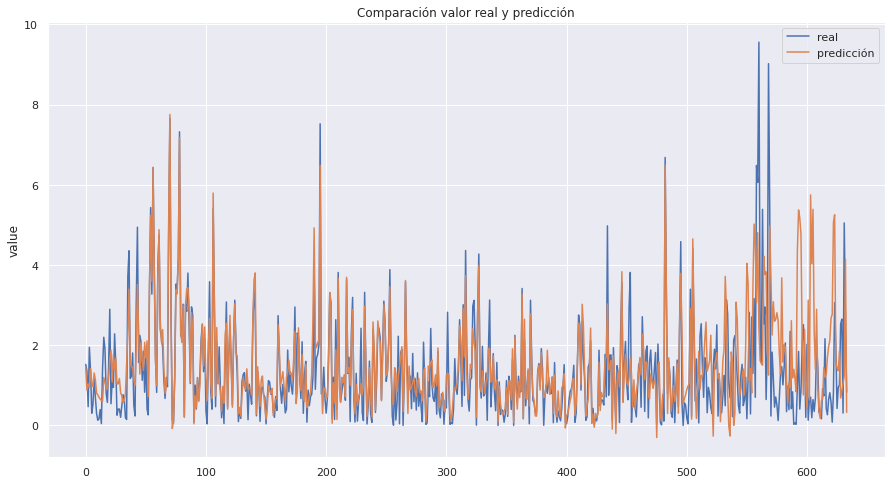

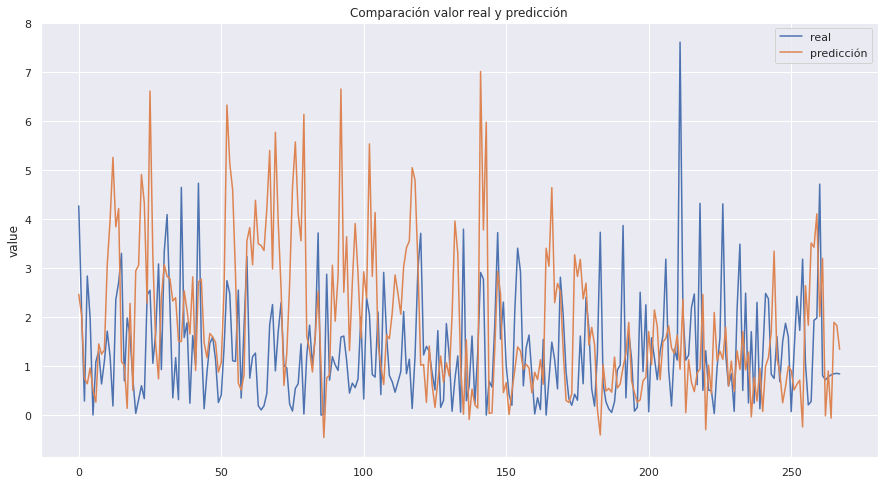

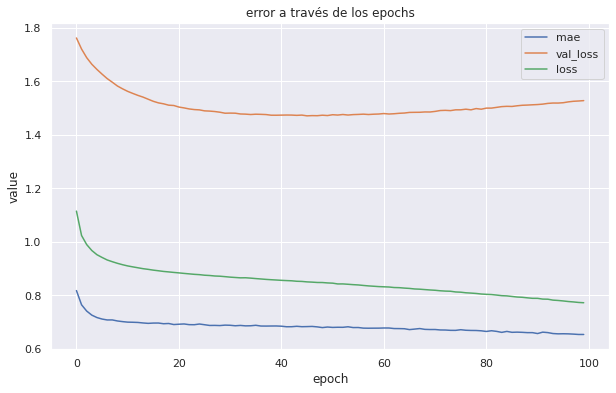

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.4353395890052654
MAE is : 0.857941839454321
RMSE is : 1.1980565883985888
MAPE is : 41.42138371207362
Evaluation metric results:
MSE is : 1.2697727349606753
MAE is : 0.8533185819312299
RMSE is : 1.1268419298910897
MAPE is : 42.69837726074316
(632, 10, 7) (632, 1)
(266, 10, 7) (266, 1)
Epoch 1/100
32/32 [==============================] - 5s 36ms/step - loss: 0.9421 - mae: 0.7239 - val_loss: 1.5051 - val_mae: 0.7855
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9164 - mae: 0.7094 - val_loss: 1.4832 - val_mae: 0.7863
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9076 - mae: 0.7027 - val_loss: 1.4665 - val_mae: 0.7878
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9028 - mae: 0.6999 - val_loss: 1.4552 - val_mae: 0.7879
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.8958 - mae: 0.6955 - v

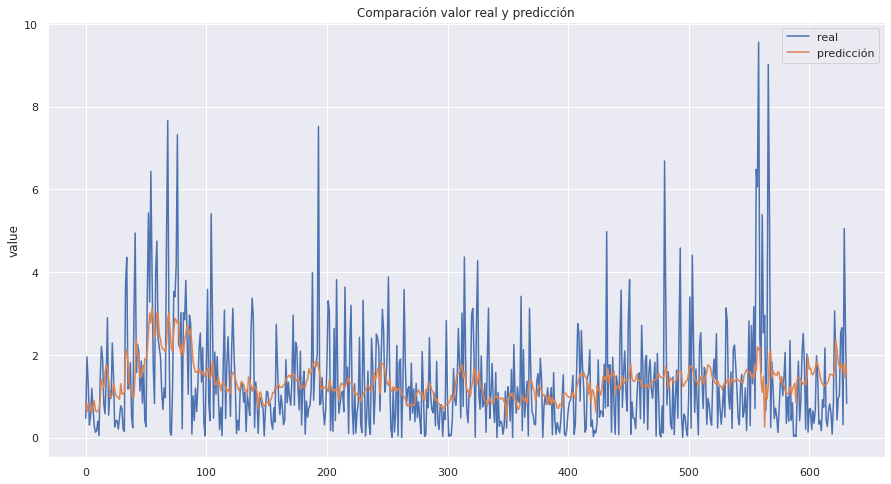

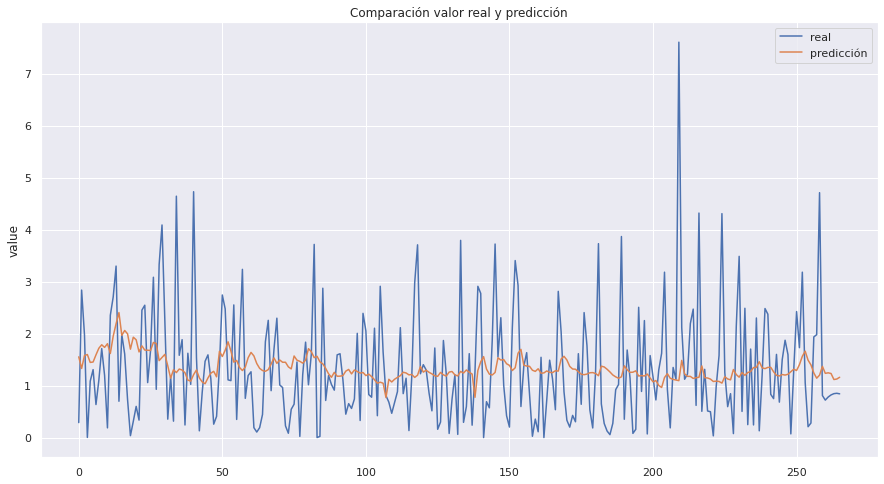

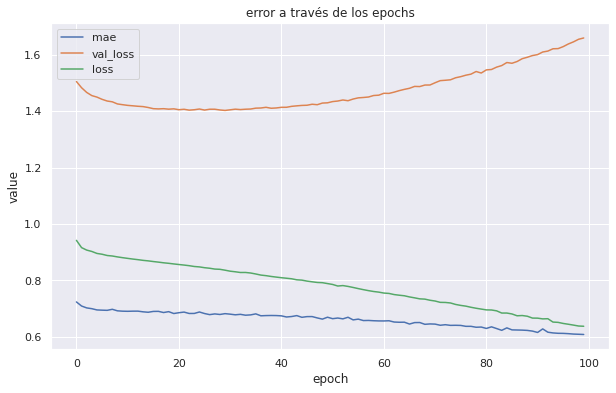

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.2995870651050485
MAE is : 0.8251546591474005
RMSE is : 1.1399943267863435
MAPE is : 40.356806842335054
Evaluation metric results:
MSE is : 1.2309791891855641
MAE is : 0.8506982123951353
RMSE is : 1.1094950153946452
MAPE is : 42.12662532674486
(632, 10, 7) (632, 1)
(266, 10, 7) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 36ms/step - loss: 1.0184 - mae: 0.7358 - val_loss: 1.6519 - val_mae: 0.8452
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9646 - mae: 0.7364 - val_loss: 1.5752 - val_mae: 0.8300
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9379 - mae: 0.7161 - val_loss: 1.5286 - val_mae: 0.8234
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9235 - mae: 0.7119 - val_loss: 1.4987 - val_mae: 0.8171
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9103 - mae: 0.7028 -

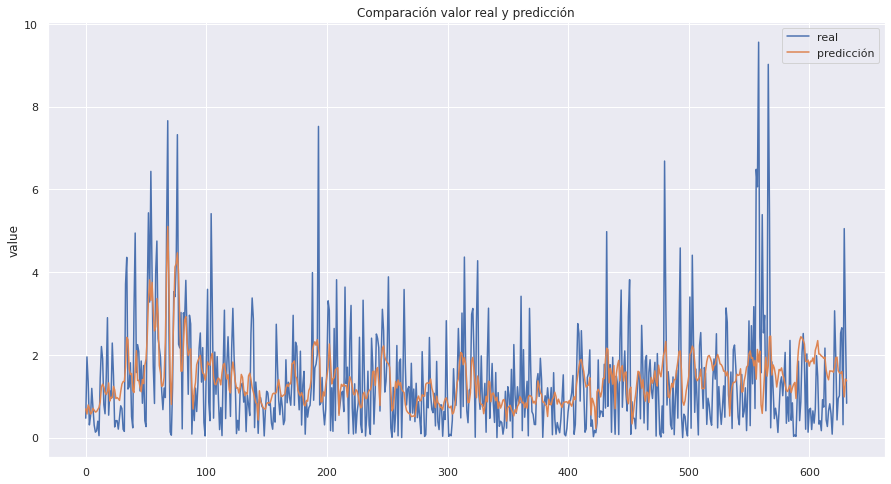

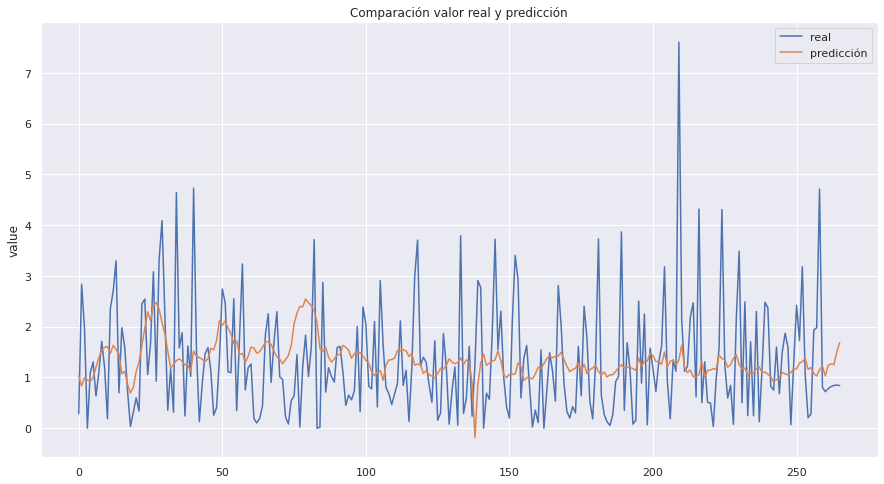

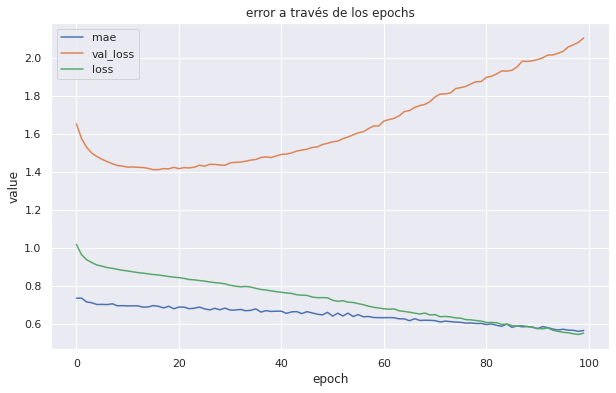

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.3223486058644407
MAE is : 0.8217975570749044
RMSE is : 1.1499341745788934
MAPE is : 40.32319019460671
Evaluation metric results:
MSE is : 1.28726282021195
MAE is : 0.8551008480056602
RMSE is : 1.1345760530753106
MAPE is : 40.6510853010149
(632, 10, 7) (632, 1)
(266, 10, 7) (266, 1)
Epoch 1/100
32/32 [==============================] - 5s 39ms/step - loss: 0.9618 - mae: 0.7071 - val_loss: 1.4126 - val_mae: 0.7802
Epoch 2/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9164 - mae: 0.7243 - val_loss: 1.3820 - val_mae: 0.7859
Epoch 3/100
32/32 [==============================] - 1s 17ms/step - loss: 0.9103 - mae: 0.7005 - val_loss: 1.3618 - val_mae: 0.7836
Epoch 4/100
32/32 [==============================] - 1s 17ms/step - loss: 0.9015 - mae: 0.7052 - val_loss: 1.3613 - val_mae: 0.7855
Epoch 5/100
32/32 [==============================] - 1s 17ms/step - loss: 0.8887 - mae: 0.6916 - val

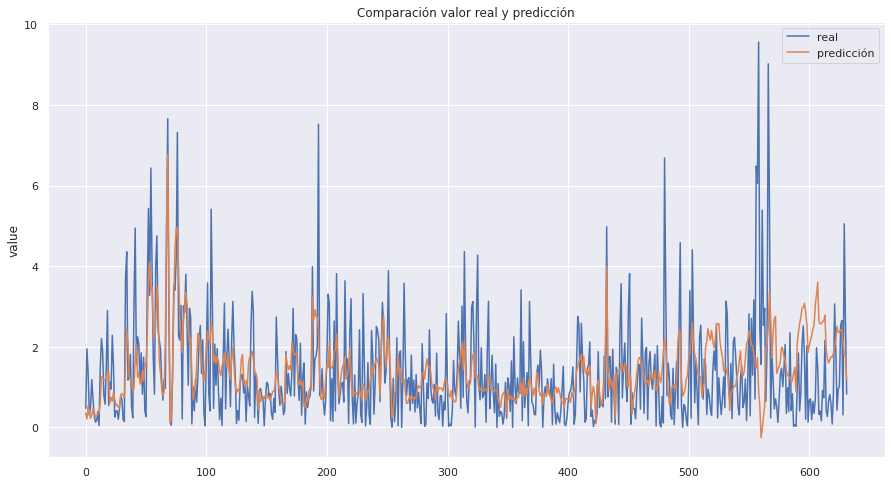

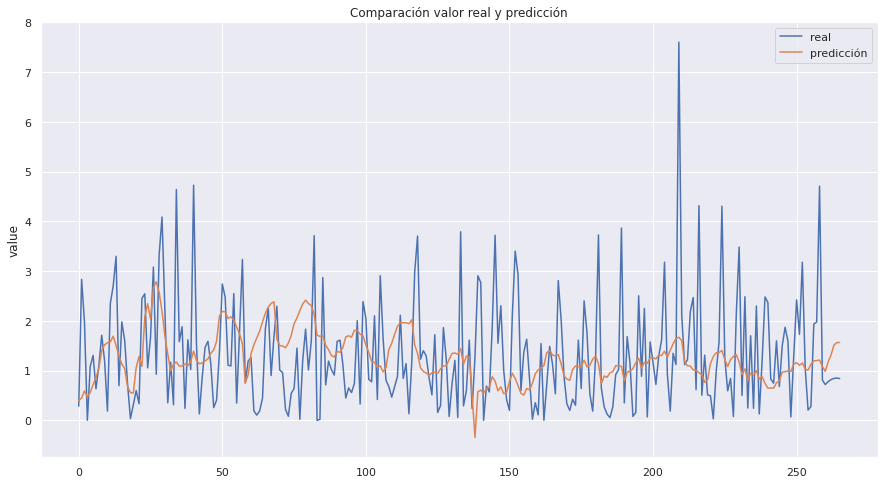

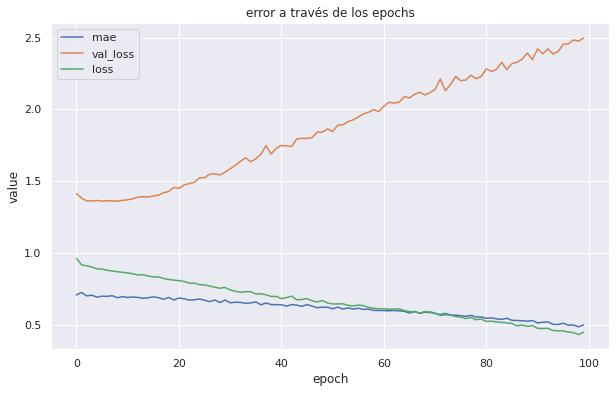

9/9 [==============================] - 0s 7ms/step
Evaluation metric results:
MSE is : 1.304431823982755
MAE is : 0.7622615831664747
RMSE is : 1.142117254918581
MAPE is : 37.5636282751084
Evaluation metric results:
MSE is : 1.4973714542935321
MAE is : 0.9740974738109952
RMSE is : 1.2236713015730705
MAPE is : 52.61903103268507
(632, 10, 7) (632, 1)
(266, 10, 7) (266, 1)
Epoch 1/100
32/32 [==============================] - 5s 52ms/step - loss: 0.9648 - mae: 0.7138 - val_loss: 1.3983 - val_mae: 0.7836
Epoch 2/100
32/32 [==============================] - 1s 27ms/step - loss: 0.9142 - mae: 0.7215 - val_loss: 1.3869 - val_mae: 0.7979
Epoch 3/100
32/32 [==============================] - 1s 27ms/step - loss: 0.9076 - mae: 0.7028 - val_loss: 1.3635 - val_mae: 0.7939
Epoch 4/100
32/32 [==============================] - 1s 27ms/step - loss: 0.9011 - mae: 0.7036 - val_loss: 1.3728 - val_mae: 0.7948
Epoch 5/100
32/32 [==============================] - 1s 23ms/step - loss: 0.8847 - mae: 0.6926 - val

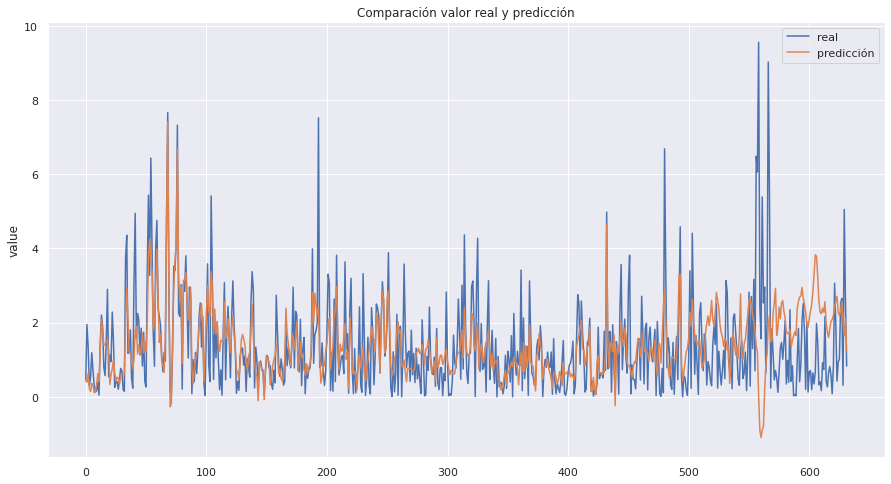

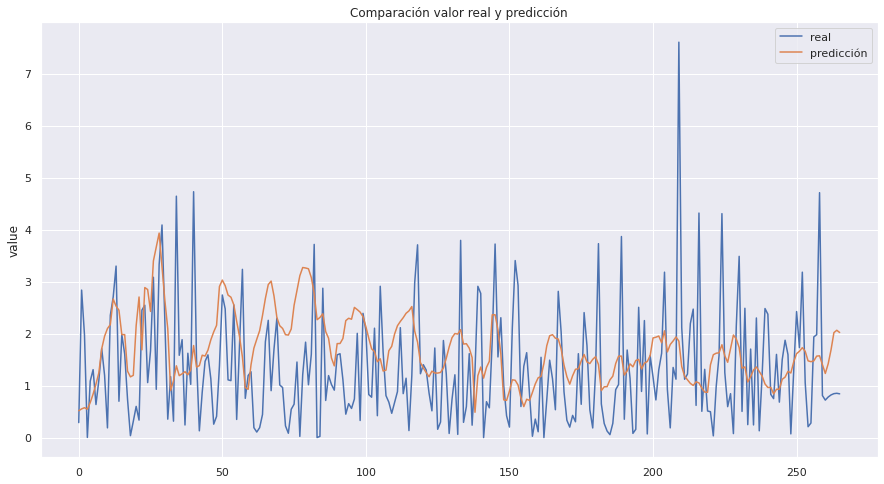

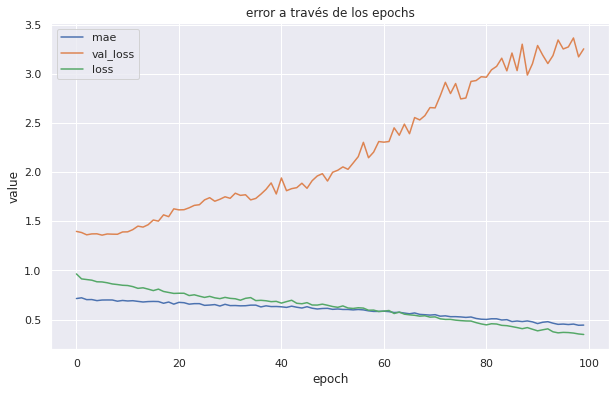

9/9 [==============================] - 0s 12ms/step
Evaluation metric results:
MSE is : 1.4602407531116381
MAE is : 0.787297211663621
RMSE is : 1.2084042175992429
MAPE is : 39.27883806658215
Evaluation metric results:
MSE is : 3.7081586630312477
MAE is : 1.4817684199108558
RMSE is : 1.9256579818418555
MAPE is : 81.42802384543855
(632, 10, 7) (632, 1)
(266, 10, 7) (266, 1)
Epoch 1/100
32/32 [==============================] - 6s 81ms/step - loss: 0.9884 - mae: 0.7251 - val_loss: 1.4053 - val_mae: 0.7868
Epoch 2/100
32/32 [==============================] - 2s 59ms/step - loss: 0.9145 - mae: 0.7200 - val_loss: 1.3756 - val_mae: 0.7968
Epoch 3/100
32/32 [==============================] - 2s 59ms/step - loss: 0.9046 - mae: 0.7022 - val_loss: 1.3433 - val_mae: 0.7957
Epoch 4/100
32/32 [==============================] - 2s 53ms/step - loss: 0.8946 - mae: 0.7038 - val_loss: 1.3652 - val_mae: 0.7919
Epoch 5/100
32/32 [==============================] - 2s 57ms/step - loss: 0.8760 - mae: 0.6923 - 

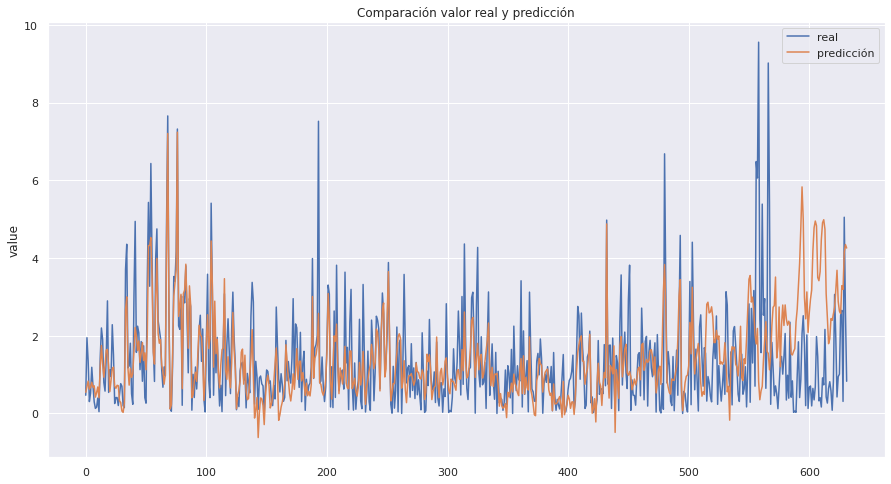

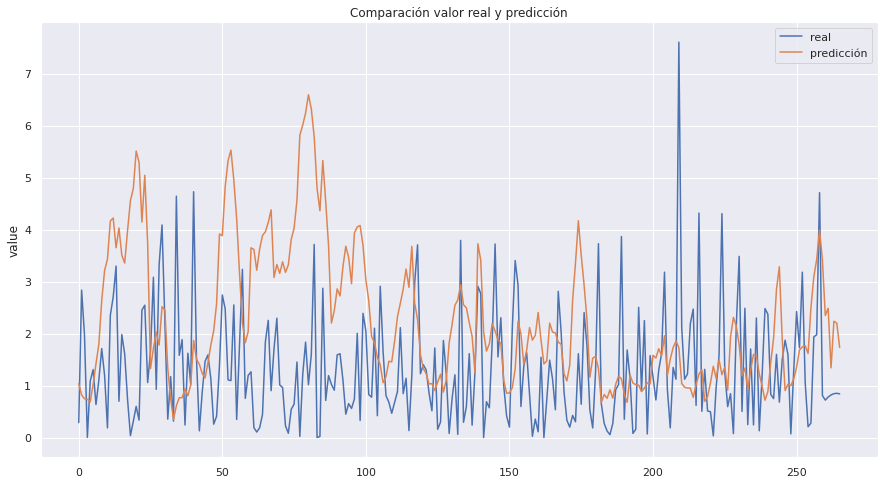

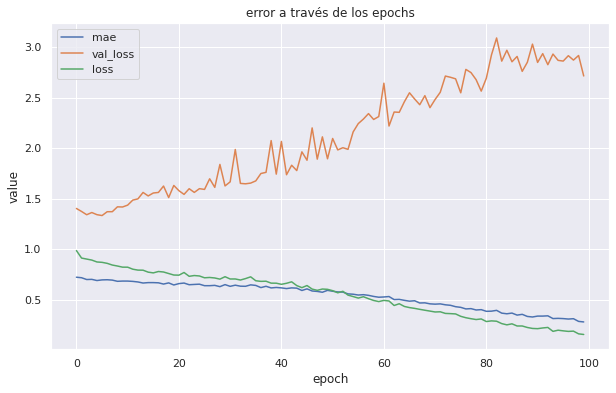

9/9 [==============================] - 0s 16ms/step
Evaluation metric results:
MSE is : 1.0452482428171646
MAE is : 0.5910646568838367
RMSE is : 1.022373827333801
MAPE is : 29.12641061767887
Evaluation metric results:
MSE is : 5.163786867578468
MAE is : 1.79769744742204
RMSE is : 2.2723967231930406
MAPE is : 98.50502514111749
(627, 15, 7) (627, 1)
(261, 15, 7) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 33ms/step - loss: 0.9553 - mae: 0.7112 - val_loss: 1.6965 - val_mae: 0.8984
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9375 - mae: 0.7081 - val_loss: 1.6862 - val_mae: 0.8958
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9291 - mae: 0.7113 - val_loss: 1.6754 - val_mae: 0.8931
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9224 - mae: 0.7100 - val_loss: 1.6696 - val_mae: 0.8921
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9176 - mae: 0.7080 - val

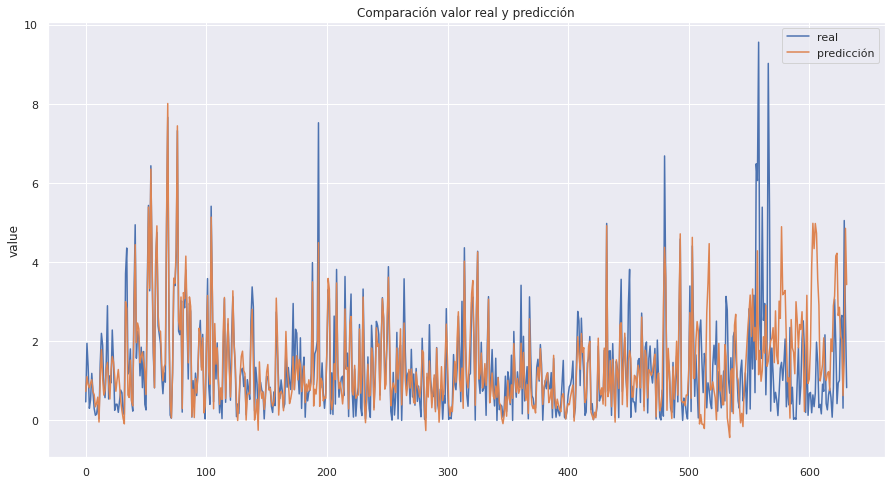

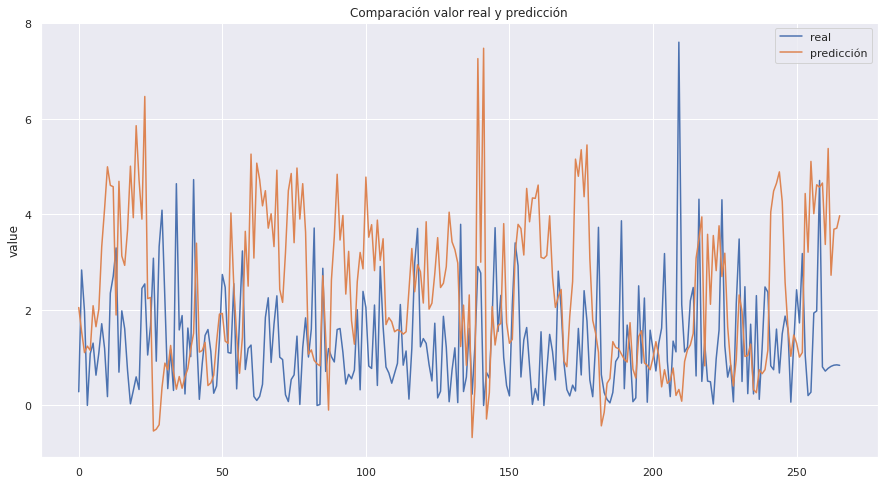

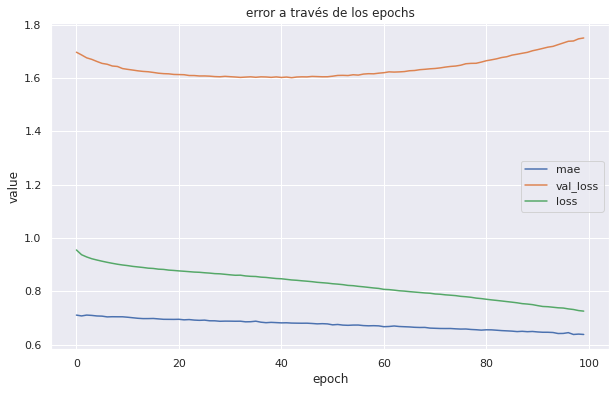

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.4466555758056756
MAE is : 0.8706610889781315
RMSE is : 1.2027699596372017
MAPE is : 43.032316157296954
Evaluation metric results:
MSE is : 1.5149335075994892
MAE is : 1.0153631047765959
RMSE is : 1.2308263515214033
MAPE is : 57.25718501036692
(627, 15, 7) (627, 1)
(261, 15, 7) (261, 1)
Epoch 1/100
32/32 [==============================] - 5s 39ms/step - loss: 0.9957 - mae: 0.7567 - val_loss: 1.5174 - val_mae: 0.7756
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9486 - mae: 0.7112 - val_loss: 1.4954 - val_mae: 0.7745
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9295 - mae: 0.7162 - val_loss: 1.4788 - val_mae: 0.7736
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9171 - mae: 0.7093 - val_loss: 1.4667 - val_mae: 0.7732
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9084 - mae: 0.7009 -

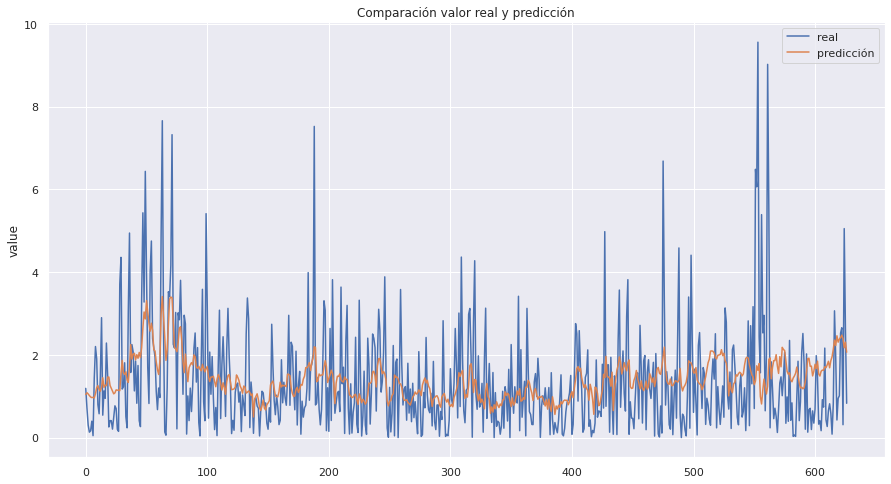

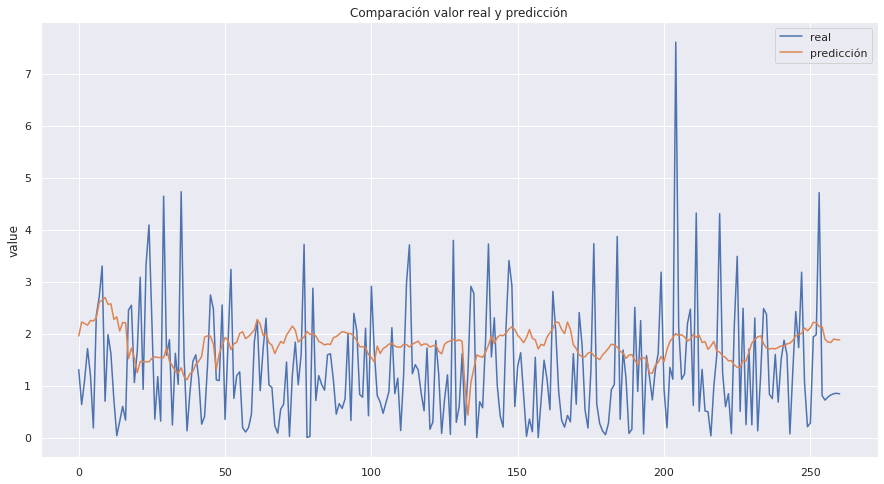

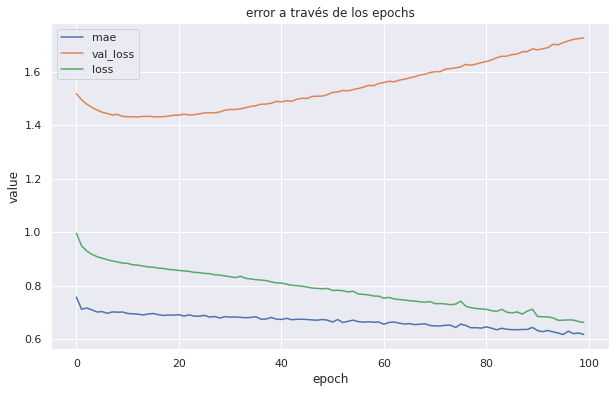

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.352032452011339
MAE is : 0.8182726039524987
RMSE is : 1.1627693030052604
MAPE is : 38.71498997858645
Evaluation metric results:
MSE is : 1.3708738905945976
MAE is : 0.8304975314929939
RMSE is : 1.1708432391206764
MAPE is : 36.09276263510336
(627, 15, 7) (627, 1)
(261, 15, 7) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 37ms/step - loss: 0.9419 - mae: 0.7226 - val_loss: 1.4834 - val_mae: 0.8011
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9111 - mae: 0.6964 - val_loss: 1.4609 - val_mae: 0.7980
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9026 - mae: 0.7140 - val_loss: 1.4481 - val_mae: 0.7981
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.8943 - mae: 0.6997 - val_loss: 1.4423 - val_mae: 0.7990
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.8896 - mae: 0.6970 - v

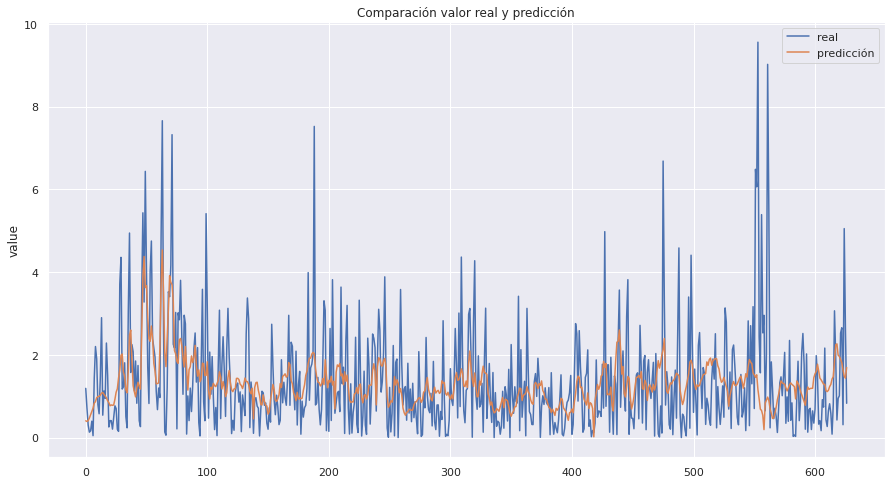

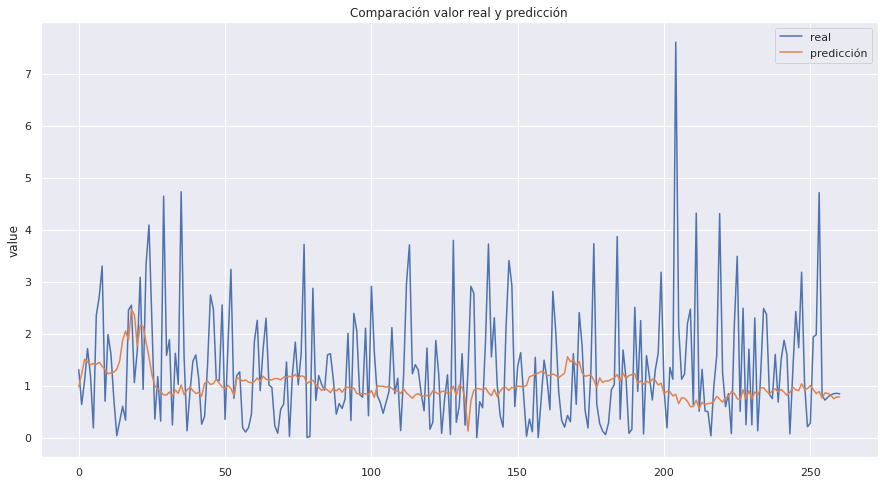

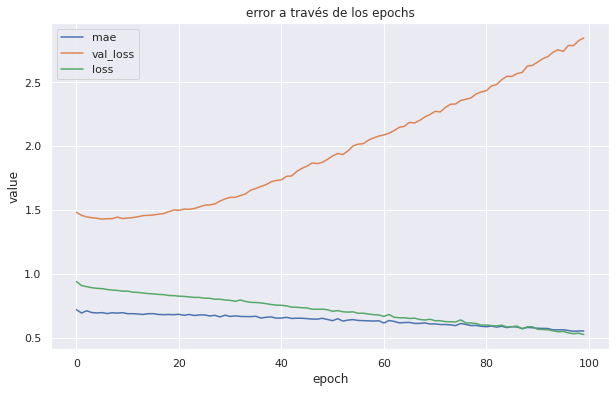

9/9 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 1.5371786841647943
MAE is : 0.8533835741358335
RMSE is : 1.2398301029434615
MAPE is : 42.77891233492962
Evaluation metric results:
MSE is : 1.710181318612722
MAE is : 1.0433463204711617
RMSE is : 1.3077390101288262
MAPE is : 58.03385413900216
(627, 15, 7) (627, 1)
(261, 15, 7) (261, 1)
Epoch 1/100
32/32 [==============================] - 5s 41ms/step - loss: 0.9720 - mae: 0.7261 - val_loss: 1.4462 - val_mae: 0.8040
Epoch 2/100
32/32 [==============================] - 1s 20ms/step - loss: 0.9161 - mae: 0.6950 - val_loss: 1.4127 - val_mae: 0.7924
Epoch 3/100
32/32 [==============================] - 1s 20ms/step - loss: 0.9063 - mae: 0.7174 - val_loss: 1.4084 - val_mae: 0.7998
Epoch 4/100
32/32 [==============================] - 1s 20ms/step - loss: 0.8994 - mae: 0.6959 - val_loss: 1.4035 - val_mae: 0.7973
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 0.8925 - mae: 0.6992 - v

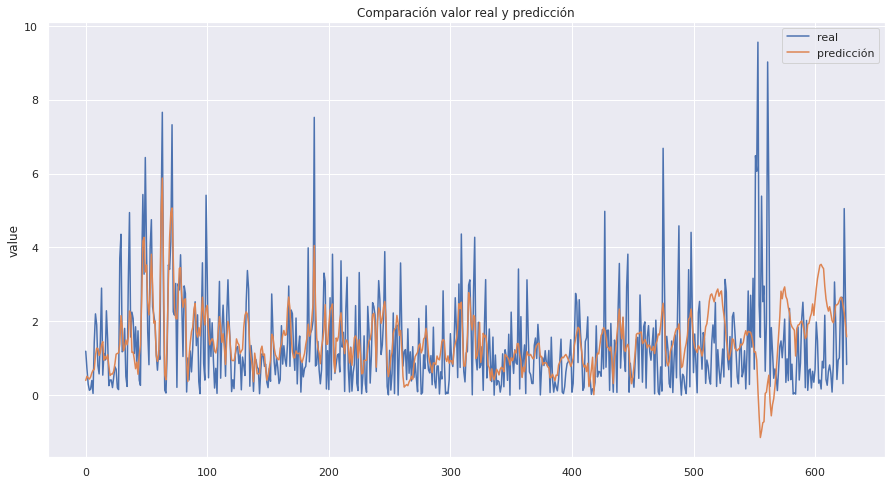

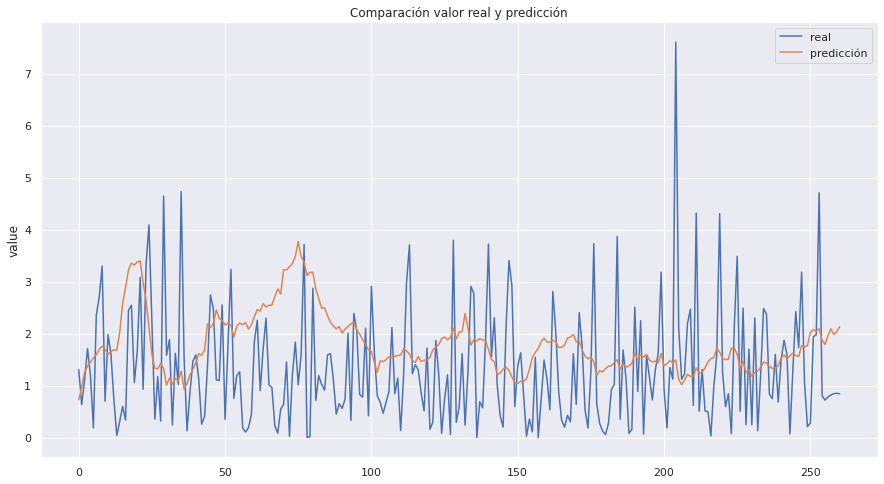

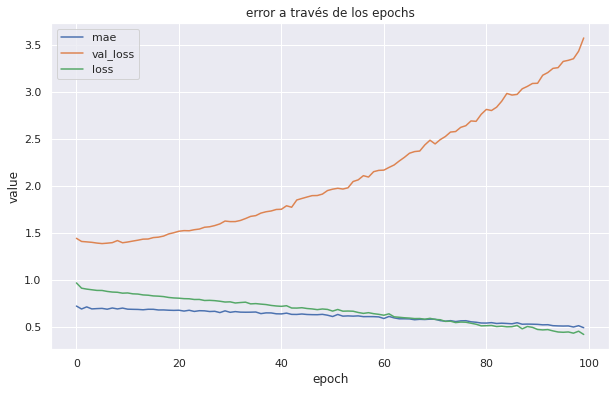

9/9 [==============================] - 0s 8ms/step
Evaluation metric results:
MSE is : 1.6403235255549484
MAE is : 0.8368223325747934
RMSE is : 1.2807511567650245
MAPE is : 41.877411802628345
Evaluation metric results:
MSE is : 2.146928697215273
MAE is : 1.1118340419637147
RMSE is : 1.465240150014759
MAPE is : 59.077271970002734
(627, 15, 7) (627, 1)
(261, 15, 7) (261, 1)
Epoch 1/100
32/32 [==============================] - 5s 55ms/step - loss: 0.9770 - mae: 0.7297 - val_loss: 1.4231 - val_mae: 0.8014
Epoch 2/100
32/32 [==============================] - 1s 33ms/step - loss: 0.9195 - mae: 0.7012 - val_loss: 1.3963 - val_mae: 0.7854
Epoch 3/100
32/32 [==============================] - 1s 37ms/step - loss: 0.8999 - mae: 0.7142 - val_loss: 1.3906 - val_mae: 0.7959
Epoch 4/100
32/32 [==============================] - 1s 34ms/step - loss: 0.8956 - mae: 0.6949 - val_loss: 1.3894 - val_mae: 0.7883
Epoch 5/100
32/32 [==============================] - 1s 34ms/step - loss: 0.8896 - mae: 0.6993 - 

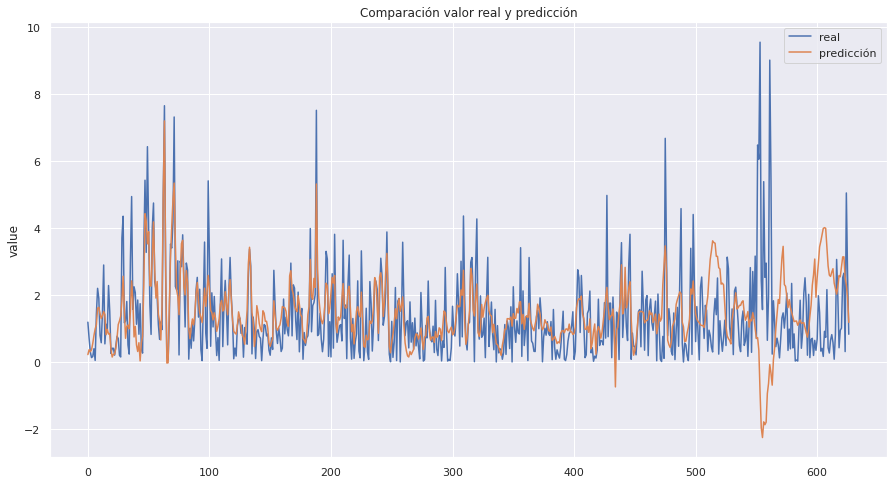

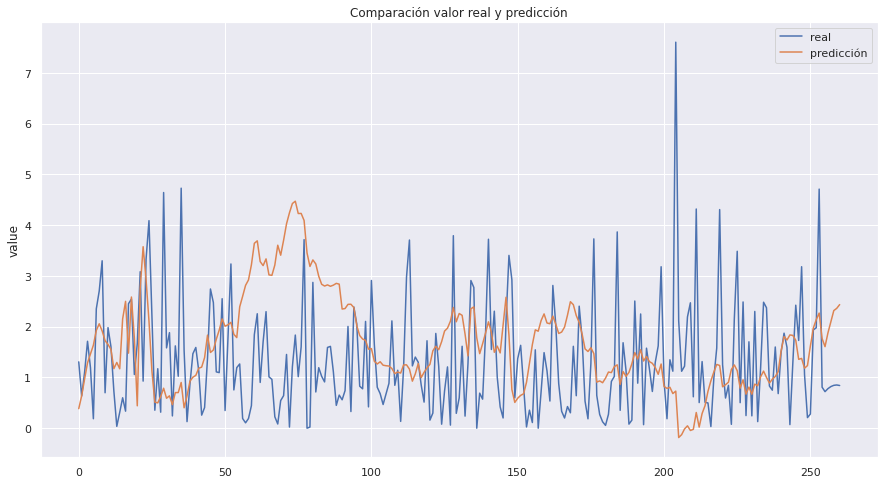

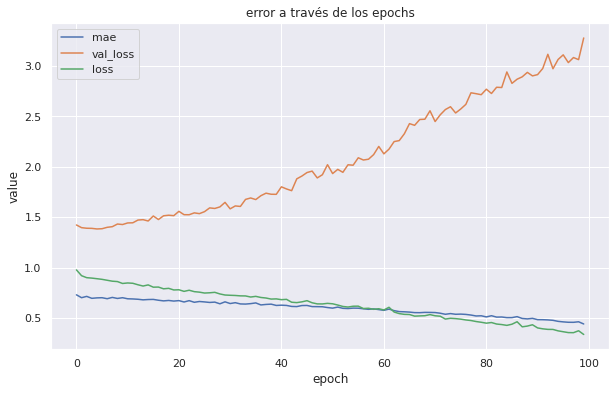

9/9 [==============================] - 0s 13ms/step
Evaluation metric results:
MSE is : 1.4023927402401706
MAE is : 0.7380328414412399
RMSE is : 1.1842266422607501
MAPE is : 36.24849890066503
Evaluation metric results:
MSE is : 2.537231251387075
MAE is : 1.2044673616870312
RMSE is : 1.5928688745113564
MAPE is : 48.87886275539428
(627, 15, 7) (627, 1)
(261, 15, 7) (261, 1)
Epoch 1/100
32/32 [==============================] - 6s 90ms/step - loss: 0.9925 - mae: 0.7346 - val_loss: 1.4212 - val_mae: 0.7966
Epoch 2/100
32/32 [==============================] - 2s 60ms/step - loss: 0.9192 - mae: 0.7010 - val_loss: 1.3916 - val_mae: 0.7782
Epoch 3/100
32/32 [==============================] - 2s 64ms/step - loss: 0.8955 - mae: 0.7133 - val_loss: 1.3606 - val_mae: 0.7870
Epoch 4/100
32/32 [==============================] - 3s 86ms/step - loss: 0.8873 - mae: 0.6965 - val_loss: 1.3837 - val_mae: 0.7821
Epoch 5/100
32/32 [==============================] - 3s 89ms/step - loss: 0.8809 - mae: 0.7002 - 

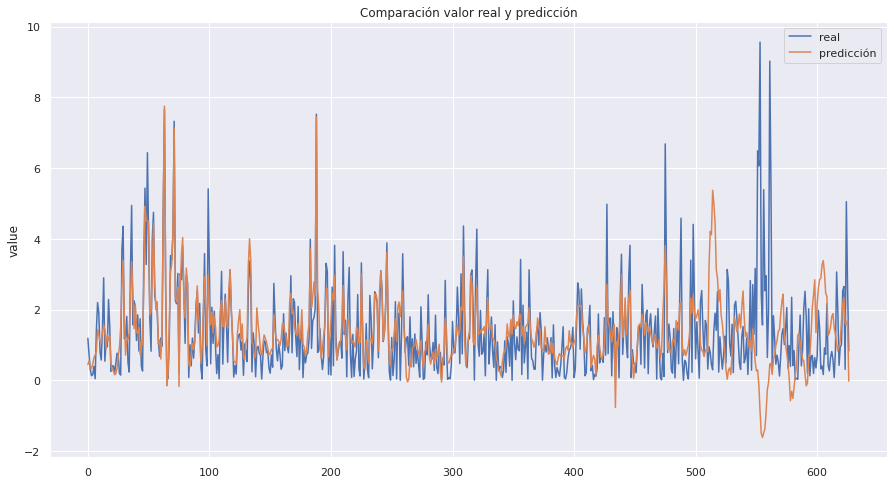

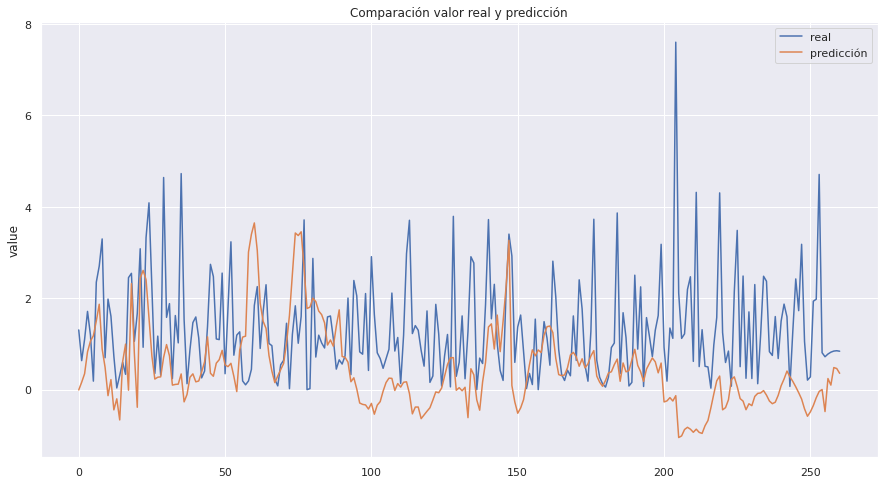

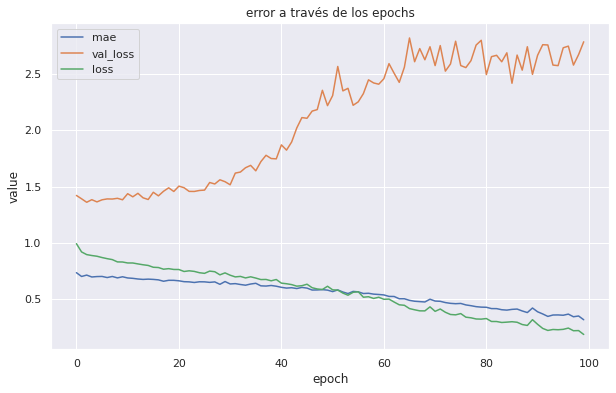

9/9 [==============================] - 0s 35ms/step
Evaluation metric results:
MSE is : 1.0938986297959494
MAE is : 0.5977886793272672
RMSE is : 1.0458960893874445
MAPE is : 30.306810502532343
Evaluation metric results:
MSE is : 2.7244836185989527
MAE is : 1.2659548662259796
RMSE is : 1.6506009870949891
MAPE is : 57.35898171286814


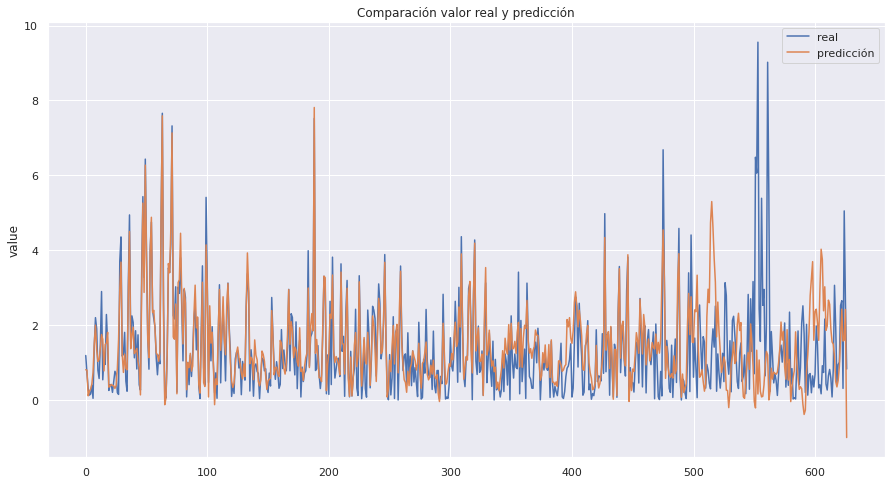

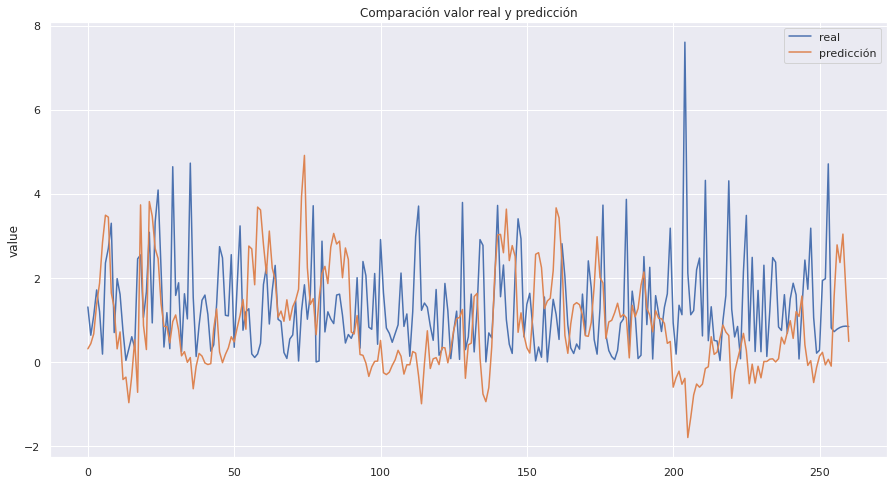

In [12]:
lags=[5,8,10,15]
neuronss=[16,32,64,128,256,512]
results_models={i:{} for i in lags}
for lg in lags:
    for neuron in neuronss:
        results_models[lg][neuron]=Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=7,epochss=100,batch_sizze=16,lag=lg)